# Exploiting Multi Spectral Imagery Information on GEO-Bench data

In [10]:
%%capture
# Install rasterio to handle tif images
!pip install rasterio
# Install CLIP dependencies
# !pip install torchvision ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
# # Install Lightning
# !pip install lightning

In [11]:
# Load libraries
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
#import clip
from tqdm import tqdm
import torch
import torch.nn as nn
import gc
import h5py
import json
import pickle
import warnings
import re
from collections import defaultdict
from pathlib import Path
from torch import optim, utils, Tensor
from torchvision.transforms import ToTensor
#import lightning as L
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as T

from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import f1_score

In [12]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Reproducibility
# L.seed_everything(0)

## CLIP

In [ ]:
# Load the CLIP model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("device =", device)
#CLIP_model, CLIP_preprocess = clip.load("ViT-B/32", device=device)

## Train, val and test datasets

Using the official splits:

<img src='https://drive.google.com/uc?id=1L4jm3KG5Lo3e3jQ1XjvusKjdsjgrAWe5' width=800>

In [14]:
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"

In [15]:
data_folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
data_folders

['m-eurosat',
 'm-bigearthnet',
 'm-brick-kiln',
 'm-forestnet',
 'm-pv4ger',
 'm-so2sat']

In [16]:
# Checking datasets dimension
for data_folder in data_folders:
    # dataset
    print("Dataset:", data_folder)
    # number of images
    print("Size:", len(os.listdir(os.path.join(data_path + data_folder))))
    # train, valid and test partition (default)
    with open(os.path.join(data_path, data_folder, 'default_partition.json'), 'r') as file:
        data = json.load(file)
        print(list(data.keys()))
        print(len(data['train']), len(data['valid']), len(data['test']))
    # metadata files
    print("Metadata:", len([f for f in os.listdir(os.path.join(data_path + data_folder)) if '.hdf5' not in f]), "files")
    print()

Dataset: m-eurosat
Size: 4012
['train', 'valid', 'test']
2000 1000 1000
Metadata: 12 files

Dataset: m-bigearthnet
Size: 22013
['train', 'valid', 'test']
20000 1000 1000
Metadata: 13 files

Dataset: m-brick-kiln
Size: 17074
['train', 'valid', 'test']
15063 999 999
Metadata: 13 files

Dataset: m-forestnet
Size: 8459
['train', 'valid', 'test']
6464 989 993
Metadata: 13 files

Dataset: m-pv4ger
Size: 13825
['train', 'valid', 'test']
11814 999 999
Metadata: 13 files

Dataset: m-so2sat
Size: 21976
['train', 'valid', 'test']
19992 986 986
Metadata: 12 files



## Dataset and DataModule

In [ ]:
# Global normalization over all channels of a single image
def normalize(array):
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())


class EuroSATMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, transform=None):
        self.df = dataframe.reset_index(drop=True) # ensure input df has continuous index
        self.transform = transform
        self.label2idx = label2idx # mapping between string labels and associated integers

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label_str = self.df.loc[idx, "label"]
        label = self.label2idx[label_str]

        with rasterio.open(img_path) as src:
            img = src.read()  # shape: [C, H, W] == [13, 64, 64]

        img = normalize(img) # GLOBAL NORMALIZATION -> all pixel values in [0, 1]
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
class EuroSATDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, batch_size=32):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EuroSATMSIDataset(self.train_df, self.label2idx)
        self.val_dataset = EuroSATMSIDataset(self.val_df, self.label2idx)
        self.test_dataset = EuroSATMSIDataset(self.test_df, self.label2idx)

    def train_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True) # optimized
        else:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2) # num_workers=0 default

    def val_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True) # optimized
        else:
            return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2) # num_workers=0 default

    def test_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2, pin_memory=True) # optimized
        else:
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2) # num_workers=0 default

## MSI Embedders

In [ ]:
class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)  # x shape: [B, in_channels, H, W] -> [B, out_channels, H, W]

In [ ]:
class MSIEmbedder2(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder2, self).__init__()
        self.proj2 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 1), # 32, 128 possible other choices for middle layer
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.proj2(x)

In [ ]:
# A SINGLE EMBEDDER TO RULE THEM ALL - transfer learning
# Define a fixed number of input channels and put to zero the ones in excess
class MSIEmbedder3(nn.Module):
    def __init__(self, max_in_channels: int = 18): # or 20
        super(MSIEmbedder3, self).__init__()
        self.max_in_channels = max_in_channels

        # The input to the model is always expected to have max_in_channels -> the forward is different
        self.proj3 = nn.Sequential(
            nn.Conv2d(max_in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        ''' x: Tensor of shape [B, C, H, W] where C == self.max_in_channels '''
        B, C, H, W = x.shape
        if C < self.max_in_channels:
            # Pad with zeros the channel dimension to make it
            # [B, c < C, H, W] -> [B, max_in_channels, H, W]
            pad_size = self.max_in_channels - C
            padding = torch.zeros((B, pad_size, H, W), device=x.device, dtype=x.dtype)
            x = torch.cat([x, padding], dim=1)
        elif C > self.max_in_channels:
            raise ValueError(f"Input has {C} channels, but max_in_channels is {self.max_in_channels}")

        return self.proj3(x)

## CLIPWithMSIEmbedder

In [ ]:
class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate=1e-3): # 1e-4, 1e-5
        super().__init__()
        self.save_hyperparameters()

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224)),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



class CLIPWithMSIEmbedder2(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate=1e-3): # 1e-4, 1e-5
        super().__init__()
        self.save_hyperparameters()

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder2(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224)),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)

Need to define train, validation and test datasets (there are official splits provided by the paper and in the `partition.json` files for each dataset)

## Training

### m-brick-kiln

In [ ]:
# Use MSIEmbedder1 with in_channels = 13
# Use MSIEmbedder2 with same config

In [ ]:
# Building train, test and validation dataframes
images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

brickkiln_labels = ['not brick kiln', 'brick kiln']
n_bands = 13

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df_brickkiln = pd.DataFrame(data)
print(test_df_brickkiln.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df_brickkiln = pd.DataFrame(data)
print(val_df_brickkiln.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df_brickkiln = pd.DataFrame(data)
print(train_df_brickkiln.head())

Splits:
['train', 'valid', 'test']
15063 999 999

TEST set: -------------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_36_950  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_79_331  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
2  examples_29_266  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
3  examples_20_682  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
4  examples_63_819  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   

  split           label  
0  test      brick kiln  
1  test  not brick kiln  
2  test      brick kiln  
3  test  not brick kiln  
4  test      brick kiln  

VALIDATION set: -------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_34_848  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examp

In [ ]:
set(test_df_brickkiln.image_id) & set(val_df_brickkiln.image_id) & set(train_df_brickkiln.image_id)

set()

In [ ]:
test_df_brickkiln.shape, val_df_brickkiln.shape, train_df_brickkiln.shape

((999, 5), (999, 5), (15063, 5))

In [ ]:
test_df_brickkiln.label.value_counts()

,count
label,
not brick kiln,663
brick kiln,336


In [ ]:
val_df_brickkiln.label.value_counts()

,count
label,
not brick kiln,663
brick kiln,336


In [ ]:
train_df_brickkiln.label.value_counts()

,count
label,
not brick kiln,10000
brick kiln,5063


In [ ]:
# Global normalization over all channels of a single image
def normalize(array):
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())

image_id = os.listdir(images_path)[0] # .hdf5 file
filename = os.path.join(images_path, image_id) # path to .hdf5 file

with h5py.File(filename, 'r') as f:
    bands = []
    for band in f.keys():
        band_data = f[band][:]
        bands.append(band_data)

img = np.stack(bands, axis=0)  # shape: [C, H, W]
# img = normalize(img)
# img = torch.tensor(img, dtype=torch.float32)
# print(img.shape)
# print(img)

In [ ]:
img.min(), img.max()

(np.float64(63.08695652173913), np.float64(3667.478260869565))

In [ ]:
f = h5py.File(filename, 'r')

In [ ]:
[(i, j) for i, j in enumerate(f.keys())]

[(0, '01 - Coastal aerosol'),
 (1, '02 - Blue'),
 (2, '03 - Green'),
 (3, '04 - Red'),
 (4, '05 - Vegetation Red Edge'),
 (5, '06 - Vegetation Red Edge'),
 (6, '07 - Vegetation Red Edge'),
 (7, '08 - NIR'),
 (8, '08A - Vegetation Red Edge'),
 (9, '09 - Water vapour'),
 (10, '10 - SWIR - Cirrus'),
 (11, '11 - SWIR'),
 (12, '12 - SWIR')]

In [ ]:
[i for i in f.keys()]

['01 - Coastal aerosol',
 '02 - Blue',
 '03 - Green',
 '04 - Red',
 '05 - Vegetation Red Edge',
 '06 - Vegetation Red Edge',
 '07 - Vegetation Red Edge',
 '08 - NIR',
 '08A - Vegetation Red Edge',
 '09 - Water vapour',
 '10 - SWIR - Cirrus',
 '11 - SWIR',
 '12 - SWIR']

In [ ]:
def compute_band_stats(df, bands):

    ''' Function to compute mean and std of spectral bands across input df.
        - df is the input df
        - bands is a list of dataset-specific bands '''

    n_bands = len(bands)

    # Initialize accumulators
    band_sum = np.zeros(n_bands, dtype=np.float64)
    band_sq_sum = np.zeros(n_bands, dtype=np.float64)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)

    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(f.keys()):

                    band = f[b][:]

                    band_sum[i] += band.sum()
                    band_sq_sum[i] += np.square(band).sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    # Compute mean and std per band
    band_means = band_sum / band_pixel_counts # total sum / total pixels
    band_stds = np.sqrt(band_sq_sum / band_pixel_counts - np.square(band_means)) # sqrt(E[x^2] - (E[x])^2)

    # Display results
    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '10 - SWIR - Cirrus',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats(val_df_brickkiln, bands)
band_stats

In [ ]:
import json

# Extract only mean/std
stats_dict = {
    f"{row['Band']}": {
        "mean": row["Mean"],
        "std": row["Std"]
    }
    for _, row in band_stats.iterrows()
}

# Save to JSON
with open("/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/m-brick-kiln_band_stats.json", "w") as f:
    json.dump(stats_dict, f, indent=2)

In [ ]:
with open("/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/m-brick-kiln_band_stats.json", "r") as f:
    band_stats = json.load(f)

# Optional: convert keys to integer if needed
band_stats = {k: v for k, v in band_stats.items()}
band_stats

{'01 - Coastal aerosol': {'mean': 582.4649221602489,
  'std': 194.04525708973162},
 '02 - Blue': {'mean': 679.1972282204389, 'std': 236.89361701577968},
 '03 - Green': {'mean': 888.0125006022311, 'std': 273.780215314392},
 '04 - Red': {'mean': 818.7769359185833, 'std': 361.36382697727834},
 '05 - Vegetation Red Edge': {'mean': 1134.2635403979903,
  'std': 358.5465522697043},
 '06 - Vegetation Red Edge': {'mean': 1949.5061915905876,
  'std': 697.6588875942155},
 '07 - Vegetation Red Edge': {'mean': 2060.4028053589373,
  'std': 787.0300242220351},
 '08 - NIR': {'mean': 2027.4076187912037, 'std': 764.7611300373509},
 '08A - Vegetation Red Edge': {'mean': 1622.7472806813937,
  'std': 786.7975635290877},
 '09 - Water vapour': {'mean': 1147.8178304117926, 'std': 707.2884107894753},
 '10 - SWIR - Cirrus': {'mean': 83.59919715450587, 'std': 36.27382035695755},
 '11 - SWIR': {'mean': 90.69062491654599, 'std': 27.60915874169563},
 '12 - SWIR': {'mean': 69.49148207658702, 'std': 24.01441699400079

In [ ]:
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


In [ ]:
class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

In [ ]:
with open("band_stats.json", "r") as f:
    band_stats = json.load(f)
band_stats = {int(k): v for k, v in band_stats.items()}

train_dataset = GEOBenchMSIDataset(train_df, label2idx, band_stats)

In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3

brickkiln_labels = ['not brick kiln', 'brick kiln']
n_bands = 13


# Normalization function
def compute_band_stats(df, bands):

    ''' Function to compute mean and std of spectral bands across input df.
        - df is the input df
        - bands is a list of dataset-specific bands '''

    n_bands = len(bands)
    # Initialize accumulators
    band_sum = np.zeros(n_bands, dtype=np.float64)
    band_sq_sum = np.zeros(n_bands, dtype=np.float64)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(f.keys()):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_sq_sum[i] += np.square(band).sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")
    # Compute mean and std per band
    band_means = band_sum / band_pixel_counts # total sum / total pixels
    band_stds = np.sqrt(band_sq_sum / band_pixel_counts - np.square(band_means)) # sqrt(E[x^2] - (E[x])^2)
    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# Extract band stats for normalization
bands = ['01 - Coastal aerosol',
          '02 - Blue',
          '03 - Green',
          '04 - Red',
          '05 - Vegetation Red Edge',
          '06 - Vegetation Red Edge',
          '07 - Vegetation Red Edge',
          '08 - NIR',
          '08A - Vegetation Red Edge',
          '09 - Water vapour',
          '10 - SWIR - Cirrus',
          '11 - SWIR',
          '12 - SWIR']

band_stats = compute_band_stats(val_df, bands) # use training set for normalization
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)



In [ ]:
# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {'not brick kiln': 0, 'brick kiln': 1} # {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {1: 0.33612162251875455, 0: 0.6638783774812455}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.6639, 0.3361])

# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-brick-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-brick")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 42     | train
----------------------------------------------------
42        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5685685873031616     │
│         val_loss          │    0.6539537310600281     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5715715885162354     │
│         test_loss         │    0.6512807011604309     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6512807011604309, 'test_acc': 0.5715715885162354}]

In [ ]:
# Use MSIEmbedder3: transfer learning

### m-pv4ger

In [ ]:
# Use MSIEmbedder1 with in_channels = 3
# Use MSIEmbedder2 with same config

# Set images path and select sample image
images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)

pv4ger_labels = ['no solar pv', 'solar pv']
n_bands = 3

# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df_pv4ger = pd.DataFrame(data)
print(test_df_pv4ger.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df_pv4ger = pd.DataFrame(data)
print(val_df_pv4ger.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df_pv4ger = pd.DataFrame(data)
print(train_df_pv4ger.head())

Splits:
['train', 'valid', 'test']
11814 999 999

TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                               image_id  \
0  8.

In [ ]:
set(test_df_pv4ger.image_id) & set(val_df_pv4ger.image_id) & set(train_df_pv4ger.image_id)

set()

In [ ]:
test_df_pv4ger.shape, val_df_pv4ger.shape, train_df_pv4ger.shape

((999, 5), (999, 5), (11814, 5))

In [ ]:
test_df_pv4ger.label.value_counts()

,count
label,
no solar pv,846
solar pv,153


In [ ]:
val_df_pv4ger.label.value_counts()

,count
label,
no solar pv,846
solar pv,153


In [ ]:
train_df_pv4ger.label.value_counts()

,count
label,
no solar pv,10000
solar pv,1814


In [ ]:
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


band_stats = compute_band_stats_up(val_df_pv4ger, bands)
band_stats

,Band,Mean,Std,Pixels
0,Blue,111.209187,41.975828,102297600
1,Green,120.649621,45.014490,102297600
2,Red,112.785495,50.687316,102297600


In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3


pv4ger_labels = ['no solar pv', 'solar pv']
n_bands = 3


# Normalization function
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats



# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
# Build dataFrame for TEST images
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# Extract band stats for normalization
bands = ['Blue',
         'Green',
         'Red']

band_stats = compute_band_stats_up(val_df_pv4ger, bands) # use training set for normalization
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)

Splits:
['train', 'valid', 'test']
11814 999 999

TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                               image_id  \
0  8.

In [ ]:
# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)} # {'no solar pv': 0, 'solar pv': 1}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {0: 0.15354663958015913, 1: 0.8464533604198409}


# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.1535, 0.8465])

In [ ]:
# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = 3,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-solar-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-brick")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 70.0MiB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 12     | train
----------------------------------------------------
12        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
image_id = os.listdir(images_path)[0] # .hdf5 file
filename = os.path.join(images_path, image_id) # path to .hdf5 file

### m-forestnet

In [ ]:
# Use MSIEmbedder1 with in_channels = 6
# Use MSIEmbedder2 with same config

# Set images path and select sample image
images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)

forestnet_labels = ['Oil palm plantation',
                    'Timber plantation',
                    'Other large-scale plantations',
                    'Grassland shrubland',
                    'Small-scale agriculture',
                    'Small-scale mixed plantation',
                    'Small-scale oil palm plantation',
                    'Mining',
                    'Fish pond',
                    'Logging',
                    'Secondary forest',
                    'Other']

n_bands = 6

# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())




Splits:
['train', 'valid', 'test']
6464 989 993

TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3  Oil palm plantation  
4 

In [ ]:
image_id = os.listdir(images_path)[2] # .hdf5 file
filename = os.path.join(images_path, image_id) # path to .hdf5 file

# Check the content of a .hdf5 file
f = h5py.File(filename, 'r')
print(type(f))
print(len(f.keys()), 'bands available')
list(f.keys())

<class 'h5py._hl.files.File'>
6 bands available


['02 - Blue_2014-06-21',
 '03 - Green_2014-06-21',
 '04 - Red_2014-06-21',
 '05 - NIR_2014-06-21',
 '06 - SWIR1_2014-06-21',
 '07 - SWIR2_2014-06-21']

In [ ]:
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import h5py

def compute_band_stats_variable_names(df):
    '''
    Compute mean and std using two-pass method for datasets
    where band names include varying timestamps.
    '''
    band_sum = defaultdict(float)
    band_sq_diff_sum = defaultdict(float)
    band_pixel_counts = defaultdict(int)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for b in f.keys():
                    base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)  # strip date
                    band = f[b][:]
                    band_sum[base_band] += band.sum()
                    band_pixel_counts[base_band] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = {k: band_sum[k] / band_pixel_counts[k] for k in band_sum}

    # Second pass: compute variance
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for b in f.keys():
                    base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)
                    band = f[b][:]
                    diff = band - band_means[base_band]
                    band_sq_diff_sum[base_band] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = {k: band_sq_diff_sum[k] / band_pixel_counts[k] for k in band_sum}
    band_stds = {k: np.sqrt(v) for k, v in band_vars.items()}

    band_stats = pd.DataFrame({
        'Band': list(band_means.keys()),
        'Mean': [band_means[k] for k in band_means],
        'Std': [band_stds[k] for k in band_means],
        'Pixels': [band_pixel_counts[k] for k in band_means]
    })

    return band_stats


band_stats = compute_band_stats_variable_names(val_df.head(100)) # use training set for normalization
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

stats_dict

{'02 - Blue': {'mean': 72.7448011322398, 'std': 18.834223413583157},
 '03 - Green': {'mean': 83.09347546813761, 'std': 17.620117460914415},
 '04 - Red': {'mean': 77.33026872550442, 'std': 18.787661167932985},
 '05 - NIR': {'mean': 122.6089608433735, 'std': 17.507870617073678},
 '06 - SWIR1': {'mean': 91.40275448178255, 'std': 15.789559416939706},
 '07 - SWIR2': {'mean': 74.24047603062854, 'std': 15.201110943750626}}

In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3


forestnet_labels = ['Oil palm plantation',
                    'Timber plantation',
                    'Other large-scale plantations',
                    'Grassland shrubland',
                    'Small-scale agriculture',
                    'Small-scale mixed plantation',
                    'Small-scale oil palm plantation',
                    'Mining',
                    'Fish pond',
                    'Logging',
                    'Secondary forest',
                    'Other']

n_bands = 6


# Normalization function
def compute_band_stats_variable_names(df):
    '''
    Compute mean and std using two-pass method for datasets
    where band names include varying timestamps.
    '''
    band_sum = defaultdict(float)
    band_sq_diff_sum = defaultdict(float)
    band_pixel_counts = defaultdict(int)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for b in f.keys():
                    base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)  # strip date
                    band = f[b][:]
                    band_sum[base_band] += band.sum()
                    band_pixel_counts[base_band] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = {k: band_sum[k] / band_pixel_counts[k] for k in band_sum}

    # Second pass: compute variance
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for b in f.keys():
                    base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)
                    band = f[b][:]
                    diff = band - band_means[base_band]
                    band_sq_diff_sum[base_band] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = {k: band_sq_diff_sum[k] / band_pixel_counts[k] for k in band_sum}
    band_stds = {k: np.sqrt(v) for k, v in band_vars.items()}

    band_stats = pd.DataFrame({
        'Band': list(band_means.keys()),
        'Mean': [band_means[k] for k in band_means],
        'Std': [band_stds[k] for k in band_means],
        'Pixels': [band_pixel_counts[k] for k in band_means]
    })

    return band_stats


# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                # stats = self.band_stats[band_name]
                base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', band_name)
                stats = self.band_stats[base_band]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# Extract band stats for normalization
band_stats = compute_band_stats_variable_names(val_df.head(100)) # use training set for normalization
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)

Splits:
['train', 'valid', 'test']
6464 989 993

TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3  Oil palm plantation  
4 

In [ ]:
# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {0: 0.15354663958015913, 1: 0.8464533604198409}


# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.1535, 0.8465])

In [ ]:
# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = 6,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-forestnet-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-forestnet")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 21     | train
----------------------------------------------------
21        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.07987866550683975    │
│         val_loss          │     2.571810007095337     │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10976837575435638    │
│         test_loss         │     2.561904191970825     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.561904191970825, 'test_acc': 0.10976837575435638}]

### m-eurosat

In [ ]:
# Use MSIEmbedder1 with in_channels = 13
# Use MSIEmbedder2 with same config

# Set images path and select sample image
images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)

eurosat_labels = ['Industrial Buildings',
                  'Residential Buildings',
                  'Annual Crop',
                  'Permanent Crop',
                  'River',
                  'Sea and Lake',
                  'Herbaceous Vegetation',
                  'Highway',
                  'Pasture',
                  'Forest']
n_bands = 13


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id                                           filename  bands  split  \
0  id_18620  /conten

In [ ]:
set(test_df.image_id) & set(val_df.image_id) & set(train_df.image_id)

set()

In [ ]:
test_df.shape, val_df.shape, train_df.shape

((1000, 6), (1000, 6), (2000, 6))

In [ ]:
test_df.label.value_counts()

,count
label,
Herbaceous Vegetation,100
Sea and Lake,100
Permanent Crop,100
Highway,100
Pasture,100
Residential Buildings,100
Annual Crop,100
River,100
Forest,100


In [ ]:
val_df.label.value_counts()

,count
label,
Industrial Buildings,100
Annual Crop,100
Herbaceous Vegetation,100
Permanent Crop,100
Highway,100
Sea and Lake,100
Residential Buildings,100
Pasture,100
Forest,100


In [ ]:
train_df.label.value_counts()

,count
label,
Residential Buildings,200
Forest,200
Herbaceous Vegetation,200
Annual Crop,200
Permanent Crop,200
Pasture,200
Highway,200
River,200
Industrial Buildings,200


In [ ]:
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '10 - SWIR - Cirrus',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(val_df.head(100), bands)
band_stats

,Band,Mean,Std,Pixels
0,01 - Coastal aerosol,1373.542917,280.768863,409600
1,02 - Blue,1139.497444,369.418907,409600
2,03 - Green,1068.967463,426.392632,409600
3,04 - Red,994.401003,621.225529,409600
4,05 - Vegetation Red Edge,1248.821919,575.265721,409600
5,06 - Vegetation Red Edge,2070.092778,839.603965,409600
6,07 - Vegetation Red Edge,2442.634595,1059.959922,409600
7,08 - NIR,2361.929417,1083.167426,409600
8,08A - Vegetation Red Edge,737.495103,381.156945,409600
9,09 - Water vapour,12.446860,5.251935,409600


In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3


eurosat_labels = ['Industrial Buildings',
                  'Residential Buildings',
                  'Annual Crop',
                  'Permanent Crop',
                  'River',
                  'Sea and Lake',
                  'Herbaceous Vegetation',
                  'Highway',
                  'Pasture',
                  'Forest']
n_bands = 13


# Normalization function
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats



# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())


# Extract band stats for normalization
bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '10 - SWIR - Cirrus',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(val_df.head(100), bands)
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id                                           filename  bands  split  \
0  id_18620  /conten

In [ ]:
# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {0: 0.15354663958015913, 1: 0.8464533604198409}


# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.1535, 0.8465])

In [ ]:
# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-eurosat-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-eurosat")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 33.5MiB/s]
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 42     | train
----------------------------------------------------
42        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.09200000017881393    │
│         val_loss          │    2.3953328132629395     │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.08900000154972076    │
│         test_loss         │    2.3885130882263184     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.3885130882263184, 'test_acc': 0.08900000154972076}]

In [ ]:
image_id = os.listdir(images_path)[0]
filename = os.path.join(images_path, image_id)

### m-so2sat

In [ ]:
# Use MSIEmbedder1 with in_channels = 18
# Use MSIEmbedder2 with same config

# Set images path and number of bands
images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)

so2sat_labels = ['Compact high rise',
                  'Compact mid rise',
                  'Compact low rise',
                  'Open high rise',
                  'Open mid rise',
                  'Open low rise',
                  'Lightweight low rise',
                  'Large low rise',
                  'Sparsely built',
                  'Heavy industry',
                  'Dense trees',
                  'Scattered trees',
                  'Bush, scrub',
                  'Low plants',
                  'Bare rock or paved',
                  'Bare soil or sand',
                  'Water']
n_bands = 18


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


Splits:
['train', 'valid', 'test']
19992 986 986

TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_357160  /content/drive/MyDriv

In [ ]:
set(test_df.image_id) & set(val_df.image_id) & set(train_df.image_id)

set()

In [ ]:
test_df.shape, val_df.shape, train_df.shape

((986, 5), (986, 5), (19992, 5))

In [ ]:
test_df.label.value_counts()

,count
label,
Open mid rise,58
Dense trees,58
"Bush, scrub",58
Scattered trees,58
Sparsely built,58
Large low rise,58
Open high rise,58
Open low rise,58
Low plants,58


In [ ]:
val_df.label.value_counts()

,count
label,
Large low rise,58
Compact high rise,58
Dense trees,58
Compact low rise,58
Bare rock or paved,58
Water,58
Open high rise,58
Heavy industry,58
Scattered trees,58


In [ ]:
train_df.label.value_counts()

,count
label,
Scattered trees,1176
Lightweight low rise,1176
Bare rock or paved,1176
Dense trees,1176
"Bush, scrub",1176
Large low rise,1176
Open high rise,1176
Open low rise,1176
Heavy industry,1176


In [ ]:
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


bands = ['01 - VH.Real',
         '02 - Blue',
         '02 - VH.Imaginary',
         '03 - Green',
         '03 - VV.Real',
         '04 - Red',
         '04 - VV.Imaginary',
         '05 - VH.LEE Filtered',
         '05 - Vegetation Red Edge',
         '06 - VV.LEE Filtered',
         '06 - Vegetation Red Edge',
         '07 - VH.LEE Filtered.Real',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08 - VV.LEE Filtered.Imaginary',
         '08A - Vegetation Red Edge',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(val_df.head(200), bands)
band_stats

,Band,Mean,Std,Pixels
0,01 - VH.Real,-0.000554,0.202735,204800
1,02 - Blue,0.133310,0.034284,204800
2,02 - VH.Imaginary,0.000009,0.200889,204800
3,03 - Green,0.121280,0.039164,204800
4,03 - VV.Real,-0.000290,0.500877,204800
5,04 - Red,0.119406,0.054395,204800
6,04 - VV.Imaginary,-0.000415,0.513136,204800
7,05 - VH.LEE Filtered,0.057686,0.349672,204800
8,05 - Vegetation Red Edge,0.129814,0.049687,204800
9,06 - VV.LEE Filtered,0.326341,2.466039,204800


In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3


so2sat_labels = ['Compact high rise',
                  'Compact mid rise',
                  'Compact low rise',
                  'Open high rise',
                  'Open mid rise',
                  'Open low rise',
                  'Lightweight low rise',
                  'Large low rise',
                  'Sparsely built',
                  'Heavy industry',
                  'Dense trees',
                  'Scattered trees',
                  'Bush, scrub',
                  'Low plants',
                  'Bare rock or paved',
                  'Bare soil or sand',
                  'Water']
n_bands = 18


# Normalization function
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats



# Dataset and DataModule class
# class GEOBenchMSIDataset(Dataset):
#     def __init__(self, dataframe, label2idx, band_stats):
#         self.df = dataframe.reset_index(drop=True)
#         self.label2idx = label2idx
#         self.band_stats = band_stats  # needed for normalization with train_df band stats

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = self.df.loc[idx, "filename"]
#         label = self.label2idx[self.df.loc[idx, "label"]]

#         with h5py.File(img_path, 'r') as f:
#             bands = []
#             for i, band_name in enumerate(f.keys()):
#                 if band_name in bands:
#                     band = f[band_name][:]
#                     stats = self.band_stats[band_name]
#                     band = (band - stats["mean"]) / stats["std"]
#                     bands.append(band)

#         img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
#         img = torch.tensor(img, dtype=torch.float32)

#         return img, label


class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, selected_bands):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats
        self.selected_bands = selected_bands  # nuova variabile

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            band_data = []
            for band_name in self.selected_bands:
                if band_name in f.keys():
                    band = f[band_name][:]
                    stats = self.band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    band_data.append(band)
                else:
                    raise KeyError(f"Banda {band_name} non trovata nel file {img_path}")

        img = np.stack(band_data, axis=0)  # [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)
        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size, selected_bands):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.selected_bands = selected_bands

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.selected_bands)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.selected_bands)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.selected_bands)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


# Extract band stats for normalization
selected_bands = [#'01 - VH.Real',
         '02 - Blue',
         #'02 - VH.Imaginary',
         '03 - Green',
         #'03 - VV.Real',
         '04 - Red',
         #'04 - VV.Imaginary',
         '05 - VH.LEE Filtered',
         '05 - Vegetation Red Edge',
         '06 - VV.LEE Filtered',
         '06 - Vegetation Red Edge',
         #'07 - VH.LEE Filtered.Real',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         #'08 - VV.LEE Filtered.Imaginary',
         '08A - Vegetation Red Edge',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(val_df.head(100), bands)

stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)


Splits:
['train', 'valid', 'test']
19992 986 986

TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_357160  /content/drive/MyDriv

In [ ]:
# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size, selected_bands)

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {0: 0.15354663958015913, 1: 0.8464533604198409}


# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.1535, 0.8465])

In [ ]:
class_weights

{14: 0.058823529411764705,
 9: 0.058823529411764705,
 0: 0.058823529411764705,
 6: 0.058823529411764705,
 2: 0.058823529411764705,
 8: 0.058823529411764705,
 11: 0.058823529411764705,
 12: 0.058823529411764705,
 7: 0.058823529411764705,
 4: 0.058823529411764705,
 16: 0.058823529411764705,
 13: 0.058823529411764705,
 3: 0.058823529411764705,
 15: 0.058823529411764705,
 5: 0.058823529411764705,
 10: 0.058823529411764705,
 1: 0.058823529411764705}

In [ ]:
weights_tensor

tensor([0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
        0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588])

In [ ]:
# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = len(bands),
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-so2sat-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-so2sat")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 39     | train
----------------------------------------------------
39        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### m-bigearthnet

In [ ]:
# Use MSIEmbedder1 with in_channels = 12
# Use MSIEmbedder2 with same config

images_folder = 'm-bigearthnet'
images_path = os.path.join(data_path, images_folder)

bigearthnet_labels = ['Agro-forestry areas',
                      'Airports',
                      'Annual crops associated with permanent crops',
                      'Bare rock',
                      'Beaches, dunes, sands',
                      'Broad-leaved forest',
                      'Burnt areas',
                      'Coastal lagoons',
                      'Complex cultivation patterns',
                      'Coniferous forest',
                      'Construction sites',
                      'Continuous urban fabric',
                      'Discontinuous urban fabric',
                      'Dump sites',
                      'Estuaries',
                      'Fruit trees and berry plantations',
                      'Green urban areas',
                      'Industrial or commercial units',
                      'Inland marshes',
                      'Intertidal flats',
                      'Land principally occupied by agriculture, with significant areas of natural vegetation',
                      'Mineral extraction sites',
                      'Mixed forest',
                      'Moors and heathland',
                      'Natural grassland',
                      'Non-irrigated arable land',
                      'Olive groves',
                      'Pastures',
                      'Peatbogs',
                      'Permanently irrigated land',
                      'Port areas',
                      'Rice fields',
                      'Road and rail networks and associated land',
                      'Salines',
                      'Salt marshes',
                      'Sclerophyllous vegetation',
                      'Sea and ocean',
                      'Sparsely vegetated areas',
                      'Sport and leisure facilities',
                      'Transitional woodland/shrub',
                      'Vineyards',
                      'Water bodies',
                      'Water courses']
n_bands = 12


# Read default partition
with open(os.path.join(data_path, images_folder, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_stats.json'), 'r') as file:
    label_map = json.load(file)


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

train_df = pd.DataFrame(data)
print(train_df.head())

Splits:
['train', 'valid', 'test']
20000 1000 1000

TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_427032  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
1  id_493029  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
2  id_513633  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
3  id_441746  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
4  id_510900  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   

                                              labels  \
0  [Complex cultivation patterns, Discontinuous u...   
1  [Coniferous forest, Permanently irrigated land...   
2  [Burnt areas, Complex cultivation patterns, La...   
3  [Airports, Broad-leaved forest, Discontinuous ...   
4  [Annual crops associated with permanent crops,...   

                          ground_truth_binary_vector  
0  

In [ ]:
set(test_df.image_id) & set(val_df.image_id) & set(train_df.image_id)

set()

In [ ]:
test_df.shape, val_df.shape, train_df.shape

((1000, 6), (1000, 6), (20000, 6))

In [ ]:
import numpy as np

# Assuming 'ground_truth_binary_vector' column is a list or array of 0s and 1s
all_vectors = np.stack(train_df["ground_truth_binary_vector"].values)
label_freq = all_vectors.sum(axis=0)
label_pos_ratio = label_freq / len(train_df)

# Print number of positive examples per class
for idx, (label, count, ratio) in enumerate(zip(bigearthnet_labels, label_freq, label_pos_ratio)):
    print(f"{idx:2d} - {label:<60} | Positives: {int(count):5d} | Ratio: {ratio:.4f}")

 0 - Agro-forestry areas                                          | Positives:  1848 | Ratio: 0.0924
 1 - Airports                                                     | Positives:   429 | Ratio: 0.0215
 2 - Annual crops associated with permanent crops                 | Positives:  1028 | Ratio: 0.0514
 3 - Bare rock                                                    | Positives:   534 | Ratio: 0.0267
 4 - Beaches, dunes, sands                                        | Positives:   667 | Ratio: 0.0333
 5 - Broad-leaved forest                                          | Positives:  5792 | Ratio: 0.2896
 6 - Burnt areas                                                  | Positives:   226 | Ratio: 0.0113
 7 - Coastal lagoons                                              | Positives:   527 | Ratio: 0.0263
 8 - Complex cultivation patterns                                 | Positives:  4847 | Ratio: 0.2424
 9 - Coniferous forest                                            | Positives:  4776 | Rati

In [ ]:
# Total number of samples
num_samples = len(train_df)

# Number of positives per class
pos_counts = label_freq
neg_counts = num_samples - pos_counts

# Avoid divide-by-zero
pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-6), dtype=torch.float32).to(device)

In [ ]:
pos_weight

tensor([ 9.8225, 45.6200, 18.4553, 36.4532, 28.9850,  2.4530, 87.4956, 36.9507,
         3.1263,  3.1876, 42.1965, 20.8579,  3.7393, 47.1928, 42.3839, 20.4592,
        34.5872, 11.5865, 23.6609, 42.0108,  2.8001, 22.5294,  2.6941, 21.3464,
        18.6271,  1.9727, 13.9365,  3.7048, 19.1816, 12.2275, 70.9424, 23.8756,
        23.7831, 87.1057, 29.9598, 15.6806,  9.4932, 39.0802, 18.2678,  2.4252,
        19.3666, 10.1545, 16.2861])

In [ ]:
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats


bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(train_df.head(100), bands)
band_stats

,Band,Mean,Std,Pixels
0,01 - Coastal aerosol,406.904244,383.616433,1440000
1,02 - Blue,511.561360,491.948264,1440000
2,03 - Green,742.223957,547.236462,1440000
3,04 - Red,755.492822,676.456093,1440000
4,05 - Vegetation Red Edge,1103.999144,690.517680,1440000
5,06 - Vegetation Red Edge,1786.779245,985.707339,1440000
6,07 - Vegetation Red Edge,2034.307622,1140.110093,1440000
7,08 - NIR,2152.424979,1247.002844,1440000
8,08A - Vegetation Red Edge,2213.563052,1234.087245,1440000
9,09 - Water vapour,2177.556186,1183.993662,1440000


In [ ]:
# MAIN -------------------------------------------------------------------------
# Load libraries
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import pickle
import clip
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchmetrics.classification import MultilabelAveragePrecision
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings("ignore")


# data_path = '../EuroSAT_MSI_data/' # the script will run inside the thesis/ folder
# checkpoint_dir = './checkpoints/'
# log_dir = './logs/'
# tb_log_dir = './tb_logs/'
batch_size = 32
num_workers = 4
learning_rate = 1e-3 #5e-3


bigearthnet_labels = ['Agro-forestry areas',
                      'Airports',
                      'Annual crops associated with permanent crops',
                      'Bare rock',
                      'Beaches, dunes, sands',
                      'Broad-leaved forest',
                      'Burnt areas',
                      'Coastal lagoons',
                      'Complex cultivation patterns',
                      'Coniferous forest',
                      'Construction sites',
                      'Continuous urban fabric',
                      'Discontinuous urban fabric',
                      'Dump sites',
                      'Estuaries',
                      'Fruit trees and berry plantations',
                      'Green urban areas',
                      'Industrial or commercial units',
                      'Inland marshes',
                      'Intertidal flats',
                      'Land principally occupied by agriculture, with significant areas of natural vegetation',
                      'Mineral extraction sites',
                      'Mixed forest',
                      'Moors and heathland',
                      'Natural grassland',
                      'Non-irrigated arable land',
                      'Olive groves',
                      'Pastures',
                      'Peatbogs',
                      'Permanently irrigated land',
                      'Port areas',
                      'Rice fields',
                      'Road and rail networks and associated land',
                      'Salines',
                      'Salt marshes',
                      'Sclerophyllous vegetation',
                      'Sea and ocean',
                      'Sparsely vegetated areas',
                      'Sport and leisure facilities',
                      'Transitional woodland/shrub',
                      'Vineyards',
                      'Water bodies',
                      'Water courses']
n_bands = 12


# Normalization function
def compute_band_stats_up(df, bands):
    ''' Compute mean and std using two-pass definition-based method. '''
    n_bands = len(bands)
    band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
    band_sum = np.zeros(n_bands, dtype=np.float64)

    # First pass: compute mean
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    band_sum[i] += band.sum()
                    band_pixel_counts[i] += band.size
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_means = band_sum / band_pixel_counts

    # Second pass: compute variance
    band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
    for filename in df['filename']:
        try:
            with h5py.File(filename, 'r') as f:
                for i, b in enumerate(bands):
                    band = f[b][:]
                    diff = band - band_means[i]
                    band_sq_diff_sum[i] += np.square(diff).sum()
        except Exception as e:
            print(f"Failed reading {filename}: {e}")

    band_vars = band_sq_diff_sum / band_pixel_counts
    band_stds = np.sqrt(band_vars)

    band_stats = pd.DataFrame({
        'Band': bands,
        'Mean': band_means,
        'Std': band_stds,
        'Pixels': band_pixel_counts
    })

    return band_stats



# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, band_stats): #label2idx,
        self.df = dataframe.reset_index(drop=True)
        #self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        #label = torch.tensor(eval(self.df.loc[idx, "ground_truth_binary_vector"], dtype=torch.float32))
        # binary_vector = ast.literal_eval(self.df.loc[idx, "ground_truth_binary_vector"])
        # label = torch.tensor(binary_vector, dtype=torch.float32)
        label = torch.tensor(self.df.loc[idx, "ground_truth_binary_vector"], dtype=torch.float32)

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                bands.append(band)

        img = np.stack(bands, axis=0)
        img = torch.tensor(img, dtype=torch.float32)
        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        #self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.band_stats) #self.label2idx,
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.band_stats) #self.label2idx,
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.band_stats) #self.label2idx,

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, num_classes, class_names, learning_rate, pos_weight):
        super().__init__()
        # self.save_hyperparameters(ignore=['class_weights'])
        # self.class_weights = class_weights
        # Instantiate mAP metrics for each stage
        self.num_classes = num_classes
        self.train_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.val_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.test_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.train_map.update(probs, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        map_score = self.train_map.compute()
        self.log("train_mAP", map_score)
        self.train_map.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.val_map.update(probs, y.int())
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        map_score = self.val_map.compute()
        self.log("val_mAP", map_score)
        self.val_map.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.test_map.update(probs, y.int())
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        map_score = self.test_map.compute()
        self.log("test_mAP", map_score)
        self.test_map.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



# MAIN EXECUTION --------------------------------------------------------------
# def main():

# parser = argparse.ArgumentParser()
# parser.add_argument('--max_epochs', type=int, default=10, help='Number of training epochs')
# args = parser.parse_args()
# max_epochs = args.max_epochs


# Build TEST, VALID and TRAIN dataframes
data_path = "/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/"
images_folder = 'm-bigearthnet'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_stats.json'), 'r') as file:
    label_map = json.load(file)


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

train_df = pd.DataFrame(data)
print(train_df.head())

# Extract band stats for normalization
bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '11 - SWIR',
         '12 - SWIR']

band_stats = compute_band_stats_up(train_df.head(100), bands)
stats_dict = {f"{row['Band']}": {
                  "mean": row["Mean"],
                  "std": row["Std"]}
              for _, row in band_stats.iterrows()}

print(stats_dict)

Splits:
['train', 'valid', 'test']
20000 1000 1000

TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_427032  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
1  id_493029  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
2  id_513633  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
3  id_441746  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
4  id_510900  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   

                                              labels  \
0  [Complex cultivation patterns, Discontinuous u...   
1  [Coniferous forest, Permanently irrigated land...   
2  [Burnt areas, Complex cultivation patterns, La...   
3  [Airports, Broad-leaved forest, Discontinuous ...   
4  [Annual crops associated with permanent crops,...   

                          ground_truth_binary_vector  
0  

In [ ]:
# 1. Encode string labels into integers
# le = LabelEncoder()
# le.fit(train_df["label"])
# label2idx = {label: idx for idx, label in enumerate(le.classes_)}
# class_names = list(label2idx.keys())

# 2. Load data module
data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, stats_dict, batch_size)

# class_counts = train_df['label'].value_counts()
# total = sum(class_counts)
# class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
# norm_factor = sum(class_weights.values()) # normalize for stability
# class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# # {0: 0.15354663958015913, 1: 0.8464533604198409}


# # Convert to tensor for use in model
# weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
# tensor([0.1535, 0.8465])

In [ ]:
# 3. Create the model -- edit for binary classification
model_1 = CLIPWithMSIEmbedder1(
    in_channels = n_bands,
    num_classes = len(bigearthnet_labels),
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    #class_weights = weights_tensor
)

# 3.1 Compile the model - can result in significant speedups
#model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="content", #checkpoint_dir,
    filename="clip-msi1-geobench-bigearthnet-{epoch:02d}-{val_mAP:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_mAP",
    mode="max",
    save_last = True
)


# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="content", name="clip-msi1-geobench-bigearthnet")

# define the logger object
#logger_tb = TensorBoardLogger(tb_log_dir, name = "clip-msi1-eurosat-lr5e-3", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    precision = 32,
    #amp_backend=None,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=[logger] #, logger_tb
)

# 7. Training
trainer.fit(model_1, datamodule=data_module)

trainer.validate(model_1, datamodule=data_module)

trainer.test(model_1, datamodule=data_module)



# if __name__ == "__main__":
#     main()


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 52.2MiB/s]
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name       | Type                       | Params | Mode 
------------------------------------------------------------------
0 | train_map  | MultilabelAveragePrecision | 0      | train
1 | val_map    | MultilabelAveragePrecision | 0      | train
2 | test_map   | MultilabelAveragePrecision | 0      | train
3 | clip_model | CLIP                       | 151 M  | eval 
4 | embedder   | MSIEmbedder1               | 39     | train
5 | loss_fn    | BCEWithLogitsLoss          | 0      | train
-------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# weights assignment -> not needed anymore
# loss function logic need to be changed

## Evaluation

In [ ]:
# Setting path and global variables
#checkpoints_path = '/content/drive/MyDrive/Thesis CLIP4EO/checkpoints'
batch_size = 32
num_workers = 2 #better than 4 in the current system
learning_rate = 1e-3

# Datasets labels
brickkiln_labels = ['not brick kiln', 'brick kiln']
pv4ger_labels = ['no solar pv', 'solar pv']
forestnet_labels = ['Oil palm plantation',
                    'Timber plantation',
                    'Other large-scale plantations',
                    'Grassland shrubland',
                    'Small-scale agriculture',
                    'Small-scale mixed plantation',
                    'Small-scale oil palm plantation',
                    'Mining',
                    'Fish pond',
                    'Logging',
                    'Secondary forest',
                    'Other']
eurosat_labels = ['Industrial Buildings',
                  'Residential Buildings',
                  'Annual Crop',
                  'Permanent Crop',
                  'River',
                  'Sea and Lake',
                  'Herbaceous Vegetation',
                  'Highway',
                  'Pasture',
                  'Forest']
so2sat_labels = ['Compact high rise',
                  'Compact mid rise',
                  'Compact low rise',
                  'Open high rise',
                  'Open mid rise',
                  'Open low rise',
                  'Lightweight low rise',
                  'Large low rise',
                  'Sparsely built',
                  'Heavy industry',
                  'Dense trees',
                  'Scattered trees',
                  'Bush, scrub',
                  'Low plants',
                  'Bare rock or paved',
                  'Bare soil or sand',
                  'Water']

### MSI m-brick-kiln

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Normalization function
# def compute_band_stats(df, bands):

#     ''' Function to compute mean and std of spectral bands across input df.
#         - df is the input df
#         - bands is a list of dataset-specific bands '''

#     n_bands = len(bands)
#     # Initialize accumulators
#     band_sum = np.zeros(n_bands, dtype=np.float64)
#     band_sq_sum = np.zeros(n_bands, dtype=np.float64)
#     band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(f.keys()):
#                     band = f[b][:]
#                     band_sum[i] += band.sum()
#                     band_sq_sum[i] += np.square(band).sum()
#                     band_pixel_counts[i] += band.size
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")
#     # Compute mean and std per band
#     band_means = band_sum / band_pixel_counts # total sum / total pixels
#     band_stds = np.sqrt(band_sq_sum / band_pixel_counts - np.square(band_means)) # sqrt(E[x^2] - (E[x])^2)
#     band_stats = pd.DataFrame({
#         'Band': bands,
#         'Mean': band_means,
#         'Std': band_stds,
#         'Pixels': band_pixel_counts
#     })

#     return band_stats


# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class MSIEmbedder2(nn.Module):
    def __init__(self, in_channels):
        super(MSIEmbedder2, self).__init__()
        self.proj2 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 1), # 32, 128 possible other choices
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.proj2(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)


class CLIPWithMSIEmbedder2(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder2(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)

In [ ]:
# Testing model using Lightning
# Load model from checkpoint

n_bands = 13

images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# Extract band stats for normalization
bands = ['01 - Coastal aerosol',
        '02 - Blue',
        '03 - Green',
        '04 - Red',
        '05 - Vegetation Red Edge',
        '06 - Vegetation Red Edge',
        '07 - Vegetation Red Edge',
        '08 - NIR',
        '08A - Vegetation Red Edge',
        '09 - Water vapour',
        '10 - SWIR - Cirrus',
        '11 - SWIR',
        '12 - SWIR']

#band_stats = compute_band_stats(train_df.head(100), bands) # use training set for normalization
stats_dict = {'01 - Coastal aerosol': {'mean': 572.2055957087905, 'std': 190.0889307054842},
              '02 - Blue': {'mean': 668.9992117136323, 'std': 234.36620456596887},
              '03 - Green': {'mean': 879.8783431092559, 'std': 272.8135839081618},
              '04 - Red': {'mean': 807.5838299572753, 'std': 358.8597359056763},
              '05 - Vegetation Red Edge': {'mean': 1127.9036140074124, 'std': 361.90117242239666},
              '06 - Vegetation Red Edge': {'mean': 1960.743811865033, 'std': 721.6547484244428},
              '07 - Vegetation Red Edge': {'mean': 2075.8353733721497, 'std': 813.7981234002524},
              '08 - NIR': {'mean': 2039.484449786802, 'std': 789.6068464172699},
              '08A - Vegetation Red Edge': {'mean': 1625.4631118677528, 'std': 788.9502406860992},
              '09 - Water vapour': {'mean': 1135.5893586747786, 'std': 692.5833292425343},
              '10 - SWIR - Cirrus': {'mean': 82.47110663023524, 'std': 36.08330117538285},
              '11 - SWIR': {'mean': 89.86596187717865, 'std': 27.555838064800113},
              '12 - SWIR': {'mean': 68.45273048564155, 'std': 23.77100676865763}}

#print("\n", stats_dict)


label2idx = {'not brick kiln': 0, 'brick kiln': 1} # {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
m_brick_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_brick_data_module.setup()

# You must pass all __init__ args (in_channels, class_names, etc.) that are not stored in the checkpoint.
# If you're unsure, check which hyperparameters were saved with:
# checkpoint = torch.load("your.ckpt")
# print(checkpoint["hyper_parameters"])


TEST set: -------------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_36_950  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_79_331  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
2  examples_29_266  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
3  examples_20_682  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
4  examples_63_819  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   

  split           label  
0  test      brick kiln  
1  test  not brick kiln  
2  test      brick kiln  
3  test  not brick kiln  
4  test      brick kiln  

VALIDATION set: -------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_34_848  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_37_728  /content/drive/MyDrive/Thesis CLIP4EO

In [ ]:
test_df.shape, val_df.shape, train_df.shape

((999, 5), (999, 5), (15063, 5))

In [ ]:
class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}
# {1: 0.33612162251875455, 0: 0.6638783774812455}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)

In [ ]:
# MODEL 1 evaluation
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-brick-epoch=73-val_acc=0.8649.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_brick_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8638638854026794     │
│         test_loss         │    0.5672981142997742     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5672981142997742, 'test_acc': 0.8638638854026794}]

In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-brick-epoch=80-val_acc=0.9399.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_brick_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.90190190076828      │
│         test_loss         │    0.4614576995372772     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4614576995372772, 'test_acc': 0.90190190076828}]

### MSI m-pv4ger


In [ ]:
# # Normalization function
# def compute_band_stats_up(df, bands):
#     ''' Compute mean and std using two-pass definition-based method. '''
#     n_bands = len(bands)
#     band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
#     band_sum = np.zeros(n_bands, dtype=np.float64)

#     # First pass: compute mean
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     band_sum[i] += band.sum()
#                     band_pixel_counts[i] += band.size
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_means = band_sum / band_pixel_counts

#     # Second pass: compute variance
#     band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     diff = band - band_means[i]
#                     band_sq_diff_sum[i] += np.square(diff).sum()
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_vars = band_sq_diff_sum / band_pixel_counts
#     band_stds = np.sqrt(band_vars)

#     band_stats = pd.DataFrame({
#         'Band': bands,
#         'Mean': band_means,
#         'Std': band_stds,
#         'Pixels': band_pixel_counts
#     })

#     return band_stats

In [ ]:
n_bands = 3

images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    # print("Splits:")
    # print(list(def_partition.keys()))
    # print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
# Build dataFrame for TEST images
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())



bands = ['Blue',
        'Green',
        'Red']

# band_stats = compute_band_stats_up(train_df.head(100), bands) # use training set for normalization
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

stats_dict = {'Blue': {'mean': 116.31626609087999, 'std': 44.517549815567},
              'Green': {'mean': 119.3753711111089, 'std': 48.118873434128005},
              'Red': {'mean': 113.10150824101702, 'std': 54.08805996406338}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)} # {'no solar pv': 0, 'solar pv': 1}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


m_pv4ger_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_pv4ger_data_module.setup()


TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                               image_id  \
0  8.293073284181014, 51.07611984081508   
1          

In [ ]:
test_df.shape, val_df.shape, train_df.shape

((999, 5), (999, 5), (11814, 5))

In [ ]:
# MODEL 1 evaluation
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-pv4ger-epoch=61-val_acc=0.9059.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_pv4ger_data_module) # CAREFUL at the dataloader passed

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9219219088554382     │
│         test_loss         │    0.5052404403686523     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5052404403686523, 'test_acc': 0.9219219088554382}]

In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-pv4ger-epoch=92-val_acc=0.9189.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_pv4ger_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9289289116859436     │
│         test_loss         │    0.45374199748039246    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.45374199748039246, 'test_acc': 0.9289289116859436}]

### MSI m-forestnet

In [ ]:
# # Normalization function
# def compute_band_stats_variable_names(df):
#     '''
#     Compute mean and std using two-pass method for datasets
#     where band names include varying timestamps.
#     '''
#     band_sum = defaultdict(float)
#     band_sq_diff_sum = defaultdict(float)
#     band_pixel_counts = defaultdict(int)

#     # First pass: compute mean
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for b in f.keys():
#                     base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)  # strip date
#                     band = f[b][:]
#                     band_sum[base_band] += band.sum()
#                     band_pixel_counts[base_band] += band.size
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_means = {k: band_sum[k] / band_pixel_counts[k] for k in band_sum}

#     # Second pass: compute variance
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for b in f.keys():
#                     base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', b)
#                     band = f[b][:]
#                     diff = band - band_means[base_band]
#                     band_sq_diff_sum[base_band] += np.square(diff).sum()
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_vars = {k: band_sq_diff_sum[k] / band_pixel_counts[k] for k in band_sum}
#     band_stds = {k: np.sqrt(v) for k, v in band_vars.items()}

#     band_stats = pd.DataFrame({
#         'Band': list(band_means.keys()),
#         'Mean': [band_means[k] for k in band_means],
#         'Std': [band_stds[k] for k in band_means],
#         'Pixels': [band_pixel_counts[k] for k in band_means]
#     })

#     return band_stats

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                # stats = self.band_stats[band_name]
                base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', band_name)
                stats = self.band_stats[base_band]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label

In [ ]:
n_bands = 6


images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# band_stats = compute_band_stats_variable_names(train_df.head(100)) # use training set for normalization
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

stats_dict = {'02 - Blue': {'mean': 72.7448011322398, 'std': 18.834223413583157},
              '03 - Green': {'mean': 83.09347546813761, 'std': 17.620117460914415},
              '04 - Red': {'mean': 77.33026872550442, 'std': 18.787661167932985},
              '05 - NIR': {'mean': 122.6089608433735, 'std': 17.507870617073678},
              '06 - SWIR1': {'mean': 91.40275448178255, 'std': 15.789559416939706},
              '07 - SWIR2': {'mean': 74.24047603062854, 'std': 15.201110943750626}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


m_forestnet_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_forestnet_data_module.setup()


TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3  Oil palm plantation  
4  Grassland shrubland  

VALIDATION set: --------

In [ ]:
# MODEL 1 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-forestnet-epoch=10-val_acc=0.0940.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_forestnet_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10674723237752914    │
│         test_loss         │    2.4411959648132324     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.4411959648132324, 'test_acc': 0.10674723237752914}]

In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-forestnet-epoch=40-val_acc=0.0961.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_forestnet_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.09869083762168884    │
│         test_loss         │    2.5710747241973877     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5710747241973877, 'test_acc': 0.09869083762168884}]

### MSI m-eurosat

In [ ]:
# Normalization function
# def compute_band_stats_up(df, bands):
#     ''' Compute mean and std using two-pass definition-based method. '''
#     n_bands = len(bands)
#     band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
#     band_sum = np.zeros(n_bands, dtype=np.float64)

#     # First pass: compute mean
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     band_sum[i] += band.sum()
#                     band_pixel_counts[i] += band.size
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_means = band_sum / band_pixel_counts

#     # Second pass: compute variance
#     band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     diff = band - band_means[i]
#                     band_sq_diff_sum[i] += np.square(diff).sum()
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_vars = band_sq_diff_sum / band_pixel_counts
#     band_stds = np.sqrt(band_vars)

#     band_stats = pd.DataFrame({
#         'Band': bands,
#         'Mean': band_means,
#         'Std': band_stds,
#         'Pixels': band_pixel_counts
#     })

#     return band_stats


# DATASET same as m-brick-kiln
# DATALOADER same as m-brick-kiln
# MODELS same as m-brick-kiln

In [ ]:
n_bands = 13

images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())


# Extract band stats for normalization
bands = ['01 - Coastal aerosol',
         '02 - Blue',
         '03 - Green',
         '04 - Red',
         '05 - Vegetation Red Edge',
         '06 - Vegetation Red Edge',
         '07 - Vegetation Red Edge',
         '08 - NIR',
         '08A - Vegetation Red Edge',
         '09 - Water vapour',
         '10 - SWIR - Cirrus',
         '11 - SWIR',
         '12 - SWIR']

# band_stats = compute_band_stats_up(train_df.head(100), bands)
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

# print(stats_dict)
stats_dict = {'01 - Coastal aerosol': {'mean': 1373.5429174804688, 'std': 280.7688626473894},
              '02 - Blue': {'mean': 1139.4974438476563, 'std': 369.4189070222807},
              '03 - Green': {'mean': 1068.9674633789064, 'std': 426.39263188044737},
              '04 - Red': {'mean': 994.4010034179687, 'std': 621.2255289284642},
              '05 - Vegetation Red Edge': {'mean': 1248.8219189453125, 'std': 575.2657210120493},
              '06 - Vegetation Red Edge': {'mean': 2070.0927783203124, 'std': 839.6039654180408},
              '07 - Vegetation Red Edge': {'mean': 2442.6345947265627, 'std': 1059.9599221650665},
              '08 - NIR': {'mean': 2361.9294165039064, 'std': 1083.167426025919},
              '08A - Vegetation Red Edge': {'mean': 737.4951025390625, 'std': 381.1569445354714},
              '09 - Water vapour': {'mean': 12.4468603515625, 'std': 5.251935413904708},
              '10 - SWIR - Cirrus': {'mean': 1914.5664526367189, 'std': 974.1973698300833},
              '11 - SWIR': {'mean': 1200.4543359375, 'std': 768.5433890352791},
              '12 - SWIR': {'mean': 2671.8944140625, 'std': 1189.4151770461576}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


m_eurosat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_eurosat_data_module.setup()


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id                                           filename  bands  split  \
0  id_18620  /conten

In [ ]:
# MODEL 1 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-eurosat-epoch=99-val_acc=0.4450.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_eurosat_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4440000057220459     │
│         test_loss         │    1.5508586168289185     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5508586168289185, 'test_acc': 0.4440000057220459}]

In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-eurosat-epoch=98-val_acc=0.6550.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_eurosat_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.675000011920929     │
│         test_loss         │    1.0080606937408447     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0080606937408447, 'test_acc': 0.675000011920929}]

### MSI m-so2sat

In [ ]:
# # Normalization function
# def compute_band_stats_up(df, bands):
#     ''' Compute mean and std using two-pass definition-based method. '''
#     n_bands = len(bands)
#     band_pixel_counts = np.zeros(n_bands, dtype=np.int64)
#     band_sum = np.zeros(n_bands, dtype=np.float64)

#     # First pass: compute mean
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     band_sum[i] += band.sum()
#                     band_pixel_counts[i] += band.size
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_means = band_sum / band_pixel_counts

#     # Second pass: compute variance
#     band_sq_diff_sum = np.zeros(n_bands, dtype=np.float64)
#     for filename in df['filename']:
#         try:
#             with h5py.File(filename, 'r') as f:
#                 for i, b in enumerate(bands):
#                     band = f[b][:]
#                     diff = band - band_means[i]
#                     band_sq_diff_sum[i] += np.square(diff).sum()
#         except Exception as e:
#             print(f"Failed reading {filename}: {e}")

#     band_vars = band_sq_diff_sum / band_pixel_counts
#     band_stds = np.sqrt(band_vars)

#     band_stats = pd.DataFrame({
#         'Band': bands,
#         'Mean': band_means,
#         'Std': band_stds,
#         'Pixels': band_pixel_counts
#     })

#     return band_stats


class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, selected_bands):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats
        self.selected_bands = selected_bands  # new variable

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            band_data = []
            for band_name in self.selected_bands:
                if band_name in f.keys():
                    band = f[band_name][:]
                    stats = self.band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    band_data.append(band)
                else:
                    raise KeyError(f"Band {band_name} not found in file {img_path}")

        img = np.stack(band_data, axis=0)  # [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)
        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size, selected_bands):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.selected_bands = selected_bands

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.selected_bands)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.selected_bands)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.selected_bands)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

In [ ]:
images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    # print("\nSplits:")
    # print(list(def_partition.keys()))
    # print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


# Extract band stats for normalization
selected_bands = [#'01 - VH.Real',
                  '02 - Blue',
                  #'02 - VH.Imaginary',
                  '03 - Green',
                  #'03 - VV.Real',
                  '04 - Red',
                  #'04 - VV.Imaginary',
                  '05 - VH.LEE Filtered',
                  '05 - Vegetation Red Edge',
                  '06 - VV.LEE Filtered',
                  '06 - Vegetation Red Edge',
                  #'07 - VH.LEE Filtered.Real',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  #'08 - VV.LEE Filtered.Imaginary',
                  '08A - Vegetation Red Edge',
                  '11 - SWIR',
                  '12 - SWIR']


# band_stats = compute_band_stats_up(train_df.head(100), selected_bands)
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

stats_dict = {'02 - Blue': {'mean': 0.12951369832779297, 'std': 0.041416877498902216},
              '03 - Green': {'mean': 0.11724833593129509, 'std': 0.051952108315916054},
              '04 - Red': {'mean': 0.1138138993057747, 'std': 0.07330840290482347},
              '05 - VH.LEE Filtered': {'mean': 0.06152846527252053, 'std': 5.456680325035277},
              '05 - Vegetation Red Edge': {'mean': 0.12716546610305954, 'std': 0.06934840587770716},
              '06 - VV.LEE Filtered': {'mean': 0.34350764473414136, 'std': 11.812638378874178},
              '06 - Vegetation Red Edge': {'mean': 0.17066448744392584, 'std': 0.0750401797551518},
              '07 - Vegetation Red Edge': {'mean': 0.19278397599902083, 'std': 0.08557120212752153},
              '08 - NIR': {'mean': 0.1854726977151807, 'std': 0.0864907033157693},
              '08A - Vegetation Red Edge': {'mean': 0.20727600167416374, 'std': 0.09395276409778816},
              '11 - SWIR': {'mean': 0.17683092157763056, 'std': 0.10236901653614466},
              '12 - SWIR': {'mean': 0.12848471039637233, 'std': 0.0922578699908829}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
m_so2sat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size, selected_bands)
m_so2sat_data_module.setup()

class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_357160  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
2  i

In [ ]:
# MODEL 1 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-so2sat-epoch=14-val_acc=0.1795.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = len(selected_bands),
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_so2sat_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1582150161266327     │
│         test_loss         │    2.6411073207855225     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.6411073207855225, 'test_acc': 0.1582150161266327}]

In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-so2sat-epoch=92-val_acc=0.1907.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = len(selected_bands),
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_so2sat_data_module)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.18458418548107147    │
│         test_loss         │    2.5679731369018555     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5679731369018555, 'test_acc': 0.18458418548107147}]

### MSI-Transfer-so2sat

In [ ]:
# ONE MODEL TO EVALUATE ON ALL SATASETS
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-so2sat-epoch=42-val_acc=0.2110.ckpt"

In [ ]:
class MSIEmbedder3(nn.Module):
    def __init__(self, max_in_channels: int = 13): # mazimum number of allowed channels
        super(MSIEmbedder3, self).__init__()
        self.max_in_channels = max_in_channels

        # The input to the model is always expected to have max_in_channels -> the forward is different
        self.proj3 = nn.Sequential(
            nn.Conv2d(max_in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        ''' x: Tensor of shape [B, C, H, W] where C == self.max_in_channels '''
        B, C, H, W = x.shape
        if C < self.max_in_channels:
            # Pad with zeros the channel dimension to make it
            # [B, c < C, H, W] -> [B, max_in_channels, H, W]
            pad_size = self.max_in_channels - C
            padding = torch.zeros((B, pad_size, H, W), device=x.device, dtype=x.dtype)
            x = torch.cat([x, padding], dim=1)
        elif C > self.max_in_channels:
            raise ValueError(f"Input has {C} channels, but max_in_channels is {self.max_in_channels}")

        return self.proj3(x)


class CLIPWithMSIEmbedder3(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder3(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of a{'n' if name[0].lower() in 'aeiou' else ''} {name.lower()} area" for name in class_names]
        # "a ... area" are added to the standard prompt
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)


In [ ]:
# def map_band_names(input_band_names, expected_band_names):
#     band_mapping = {}
#     for expected in expected_band_names:
#         matched = False
#         for i, input_band in enumerate(input_band_names):
#             # Normalize both strings to lower-case and remove non-alphanumerics
#             norm_expected = re.sub(r'\W+', '', expected.lower())
#             norm_input = re.sub(r'\W+', '', input_band.lower())
#             if norm_expected in norm_input or norm_input in norm_expected:
#                 band_mapping[expected] = i
#                 matched = True
#                 break
#         if not matched:
#             band_mapping[expected] = None  # Will pad this one
#     return band_mapping

def reorder_and_pad_bands(image_tensor, band_mapping):
    C_in, H, W = image_tensor.shape
    C_out = len(band_mapping.keys())
    output_tensor = torch.zeros((C_out, H, W), dtype=image_tensor.dtype, device=image_tensor.device)

    #band_mapping = map_band_names(input_band_names, expected_band_names)

    for i, expected_band in enumerate(band_mapping.keys()):
        idx = band_mapping[expected_band]
        if idx is not None:
            output_tensor[i] = image_tensor[idx]

    return output_tensor

In [ ]:
# # original bands that MSITs was trained on
# training_bands = ['02 - Blue',
#                   '03 - Green',
#                   '04 - Red',
#                   '05 - VH.LEE Filtered',
#                   '05 - Vegetation Red Edge',
#                   '06 - VV.LEE Filtered',
#                   '06 - Vegetation Red Edge',
#                   '07 - Vegetation Red Edge',
#                   '08 - NIR',
#                   '08A - Vegetation Red Edge',
#                   '11 - SWIR',
#                   '12 - SWIR']

# bands = ['02 - Blue',
#          '03 - Green',
#          '04 - Red',
#          '05 - NIR',
#          '06 - SWIR1',
#          '07 - SWIR2']


# map_band_names(bands, training_bands)

In [ ]:
# ### BAND MAPPINGS ###

# band_mapping_brick_eurosat = {'02 - Blue': 1,
#                               '03 - Green': 2,
#                               '04 - Red': 3,
#                               '05 - VH.LEE Filtered': None,
#                               '05 - Vegetation Red Edge': 4,
#                               '06 - VV.LEE Filtered': None,
#                               '06 - Vegetation Red Edge': 5,
#                               '07 - Vegetation Red Edge': 6,
#                               '08 - NIR': 7,
#                               '08A - Vegetation Red Edge': 8,
#                               '11 - SWIR': 11,
#                               '12 - SWIR': 12}


# band_mapping_pv4ger = {'02 - Blue': 0,
#                         '03 - Green': 1,
#                         '04 - Red': 2,
#                         '05 - VH.LEE Filtered': None,
#                         '05 - Vegetation Red Edge': None,
#                         '06 - VV.LEE Filtered': None,
#                         '06 - Vegetation Red Edge': None,
#                         '07 - Vegetation Red Edge': None,
#                         '08 - NIR': None,
#                         '08A - Vegetation Red Edge': None,
#                         '11 - SWIR': None,
#                         '12 - SWIR': None}


# band_mapping_forestnet = {'02 - Blue': 0,
#                           '03 - Green': 1,
#                           '04 - Red': 2,
#                           '05 - VH.LEE Filtered': None,
#                           '05 - Vegetation Red Edge': None,
#                           '06 - VV.LEE Filtered': None,
#                           '06 - Vegetation Red Edge': None,
#                           '07 - Vegetation Red Edge': None,
#                           '08 - NIR': 3,
#                           '08A - Vegetation Red Edge': None,
#                           '11 - SWIR': 4,
#                           '12 - SWIR': 5}

In [ ]:
print("\nDATASET: m-brick-kiln =================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping) # reorder and pad channels -> same shape as above

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, band_mapping, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 13

images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())

print()
print()

#band_stats = compute_band_stats(train_df.head(100), bands) # use training set for normalization
stats_dict = {'01 - Coastal aerosol': {'mean': 572.2055957087905, 'std': 190.0889307054842},
              '02 - Blue': {'mean': 668.9992117136323, 'std': 234.36620456596887},
              '03 - Green': {'mean': 879.8783431092559, 'std': 272.8135839081618},
              '04 - Red': {'mean': 807.5838299572753, 'std': 358.8597359056763},
              '05 - Vegetation Red Edge': {'mean': 1127.9036140074124, 'std': 361.90117242239666},
              '06 - Vegetation Red Edge': {'mean': 1960.743811865033, 'std': 721.6547484244428},
              '07 - Vegetation Red Edge': {'mean': 2075.8353733721497, 'std': 813.7981234002524},
              '08 - NIR': {'mean': 2039.484449786802, 'std': 789.6068464172699},
              '08A - Vegetation Red Edge': {'mean': 1625.4631118677528, 'std': 788.9502406860992},
              '09 - Water vapour': {'mean': 1135.5893586747786, 'std': 692.5833292425343},
              '10 - SWIR - Cirrus': {'mean': 82.47110663023524, 'std': 36.08330117538285},
              '11 - SWIR': {'mean': 89.86596187717865, 'std': 27.555838064800113},
              '12 - SWIR': {'mean': 68.45273048564155, 'std': 23.77100676865763}}


label2idx = {'not brick kiln': 0, 'brick kiln': 1} # {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


band_mapping_brick_eurosat = {'02 - Blue': 1,
                              '03 - Green': 2,
                              '04 - Red': 3,
                              '05 - VH.LEE Filtered': None,
                              '05 - Vegetation Red Edge': 4,
                              '06 - VV.LEE Filtered': None,
                              '06 - Vegetation Red Edge': 5,
                              '07 - Vegetation Red Edge': 6,
                              '08 - NIR': 7,
                              '08A - Vegetation Red Edge': 8,
                              '11 - SWIR': 11,
                              '12 - SWIR': 12}

# 2. Load data module
m_brick_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_brick_eurosat, batch_size)
m_brick_data_module.setup()


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_brick_data_module)


DATASET: m-brick-kiln =================================================


TEST set: -------------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_36_950  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_79_331  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
2  examples_29_266  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
3  examples_20_682  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
4  examples_63_819  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   

  split           label  
0  test      brick kiln  
1  test  not brick kiln  
2  test      brick kiln  
3  test  not brick kiln  
4  test      brick kiln  

VALIDATION set: -------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_34_848  /content/drive/MyDrive/Thesis CLIP4EO/GEO-B

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5635635852813721     │
│         test_loss         │     0.661009669303894     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.661009669303894, 'test_acc': 0.5635635852813721}]

In [ ]:
print("\nDATASET: m-pv4ger =====================================================\n")

n_bands = 3

images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    # print("Splits:")
    # print(list(def_partition.keys()))
    # print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
# Build dataFrame for TEST images
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


# band_stats = compute_band_stats_up(train_df.head(100), bands) # use training set for normalization
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

stats_dict = {'Blue': {'mean': 116.31626609087999, 'std': 44.517549815567},
              'Green': {'mean': 119.3753711111089, 'std': 48.118873434128005},
              'Red': {'mean': 113.10150824101702, 'std': 54.08805996406338}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)} # {'no solar pv': 0, 'solar pv': 1}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_pv4ger = {'02 - Blue': 0,
                        '03 - Green': 1,
                        '04 - Red': 2,
                        '05 - VH.LEE Filtered': None,
                        '05 - Vegetation Red Edge': None,
                        '06 - VV.LEE Filtered': None,
                        '06 - Vegetation Red Edge': None,
                        '07 - Vegetation Red Edge': None,
                        '08 - NIR': None,
                        '08A - Vegetation Red Edge': None,
                        '11 - SWIR': None,
                        '12 - SWIR': None}


m_pv4ger_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_pv4ger, batch_size)
m_pv4ger_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule=m_pv4ger_data_module)


DATASET: m-pv4ger =====================================================


TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                       

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7197197079658508     │
│         test_loss         │    0.6412553787231445     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6412553787231445, 'test_acc': 0.7197197079658508}]

In [ ]:
del test_df, val_df, train_df, m_pv4ger_data_module, model, trainer

In [ ]:
print("\nDATASET: m-eurosat ====================================================\n")

n_bands = 13

images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())

# band_stats = compute_band_stats_up(train_df.head(100), bands)
# stats_dict = {f"{row['Band']}": {
#                 "mean": row["Mean"],
#                 "std": row["Std"]}
#             for _, row in band_stats.iterrows()}

# print(stats_dict)
stats_dict = {'01 - Coastal aerosol': {'mean': 1373.5429174804688, 'std': 280.7688626473894},
              '02 - Blue': {'mean': 1139.4974438476563, 'std': 369.4189070222807},
              '03 - Green': {'mean': 1068.9674633789064, 'std': 426.39263188044737},
              '04 - Red': {'mean': 994.4010034179687, 'std': 621.2255289284642},
              '05 - Vegetation Red Edge': {'mean': 1248.8219189453125, 'std': 575.2657210120493},
              '06 - Vegetation Red Edge': {'mean': 2070.0927783203124, 'std': 839.6039654180408},
              '07 - Vegetation Red Edge': {'mean': 2442.6345947265627, 'std': 1059.9599221650665},
              '08 - NIR': {'mean': 2361.9294165039064, 'std': 1083.167426025919},
              '08A - Vegetation Red Edge': {'mean': 737.4951025390625, 'std': 381.1569445354714},
              '09 - Water vapour': {'mean': 12.4468603515625, 'std': 5.251935413904708},
              '10 - SWIR - Cirrus': {'mean': 1914.5664526367189, 'std': 974.1973698300833},
              '11 - SWIR': {'mean': 1200.4543359375, 'std': 768.5433890352791},
              '12 - SWIR': {'mean': 2671.8944140625, 'std': 1189.4151770461576}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_brick_eurosat = {'02 - Blue': 1,
                              '03 - Green': 2,
                              '04 - Red': 3,
                              '05 - VH.LEE Filtered': None,
                              '05 - Vegetation Red Edge': 4,
                              '06 - VV.LEE Filtered': None,
                              '06 - Vegetation Red Edge': 5,
                              '07 - Vegetation Red Edge': 6,
                              '08 - NIR': 7,
                              '08A - Vegetation Red Edge': 8,
                              '11 - SWIR': 11,
                              '12 - SWIR': 12}


m_eurosat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_brick_eurosat, batch_size)
m_eurosat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_eurosat_data_module)


DATASET: m-eurosat ====================================================


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id               

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1679999977350235     │
│         test_loss         │    2.2269201278686523     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.2269201278686523, 'test_acc': 0.1679999977350235}]

In [ ]:
del test_df, val_df, train_df, m_eurosat_data_module, model, trainer

In [ ]:
print("\nDATASET: m-forestnet ==================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                # stats = self.band_stats[band_name]
                base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', band_name) # a regex handles the possible name variations
                stats = self.band_stats[base_band]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, band_mapping, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))



n_bands = 6


images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


stats_dict = {'02 - Blue': {'mean': 72.7448011322398, 'std': 18.834223413583157},
              '03 - Green': {'mean': 83.09347546813761, 'std': 17.620117460914415},
              '04 - Red': {'mean': 77.33026872550442, 'std': 18.787661167932985},
              '05 - NIR': {'mean': 122.6089608433735, 'std': 17.507870617073678},
              '06 - SWIR1': {'mean': 91.40275448178255, 'std': 15.789559416939706},
              '07 - SWIR2': {'mean': 74.24047603062854, 'std': 15.201110943750626}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_forestnet = {'02 - Blue': 0,
                          '03 - Green': 1,
                          '04 - Red': 2,
                          '05 - VH.LEE Filtered': None,
                          '05 - Vegetation Red Edge': None,
                          '06 - VV.LEE Filtered': None,
                          '06 - Vegetation Red Edge': None,
                          '07 - Vegetation Red Edge': None,
                          '08 - NIR': 3,
                          '08A - Vegetation Red Edge': None,
                          '11 - SWIR': 4,
                          '12 - SWIR': 5}


m_forestnet_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_forestnet, batch_size)
m_forestnet_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_forestnet_data_module)


DATASET: m-forestnet ==================================================


TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.0876132920384407     │
│         test_loss         │    2.5178451538085938     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5178451538085938, 'test_acc': 0.0876132920384407}]

In [ ]:
del train_df, val_df, test_df, trainer, model, m_forestnet_data_module

In [ ]:
print("\nDATASET: m-so2sat =====================================================\n")

class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, selected_bands):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats
        self.selected_bands = selected_bands  # new variable

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            band_data = []
            for band_name in self.selected_bands:
                if band_name in f.keys():
                    band = f[band_name][:]
                    stats = self.band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    band_data.append(band)
                else:
                    raise KeyError(f"Band {band_name} not found in file {img_path}")

        img = np.stack(band_data, axis=0)  # [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)
        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size, selected_bands):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.selected_bands = selected_bands

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.selected_bands)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.selected_bands)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.selected_bands)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    # print("\nSplits:")
    # print(list(def_partition.keys()))
    # print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


# Extract band stats for normalization
selected_bands = [#'01 - VH.Real',
                  '02 - Blue',
                  #'02 - VH.Imaginary',
                  '03 - Green',
                  #'03 - VV.Real',
                  '04 - Red',
                  #'04 - VV.Imaginary',
                  '05 - VH.LEE Filtered',
                  '05 - Vegetation Red Edge',
                  '06 - VV.LEE Filtered',
                  '06 - Vegetation Red Edge',
                  #'07 - VH.LEE Filtered.Real',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  #'08 - VV.LEE Filtered.Imaginary',
                  '08A - Vegetation Red Edge',
                  '11 - SWIR',
                  '12 - SWIR']


stats_dict = {'02 - Blue': {'mean': 0.12951369832779297, 'std': 0.041416877498902216},
              '03 - Green': {'mean': 0.11724833593129509, 'std': 0.051952108315916054},
              '04 - Red': {'mean': 0.1138138993057747, 'std': 0.07330840290482347},
              '05 - VH.LEE Filtered': {'mean': 0.06152846527252053, 'std': 5.456680325035277},
              '05 - Vegetation Red Edge': {'mean': 0.12716546610305954, 'std': 0.06934840587770716},
              '06 - VV.LEE Filtered': {'mean': 0.34350764473414136, 'std': 11.812638378874178},
              '06 - Vegetation Red Edge': {'mean': 0.17066448744392584, 'std': 0.0750401797551518},
              '07 - Vegetation Red Edge': {'mean': 0.19278397599902083, 'std': 0.08557120212752153},
              '08 - NIR': {'mean': 0.1854726977151807, 'std': 0.0864907033157693},
              '08A - Vegetation Red Edge': {'mean': 0.20727600167416374, 'std': 0.09395276409778816},
              '11 - SWIR': {'mean': 0.17683092157763056, 'std': 0.10236901653614466},
              '12 - SWIR': {'mean': 0.12848471039637233, 'std': 0.0922578699908829}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


# 2. Load data module
m_so2sat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size, selected_bands)
m_so2sat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_so2sat_data_module)


DATASET: m-so2sat =====================================================


TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_35716

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.20081135630607605    │
│         test_loss         │    2.5613389015197754     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5613389015197754, 'test_acc': 0.20081135630607605}]

### MSI-Transfer-EuroSAT

In [ ]:
# ONE MODEL TO EVALUATE ON ALL SATASETS

# First try with MSI3 - 2 layers
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-eurosat-epoch=89-val_acc=0.8254.ckpt"

In [ ]:
class MSIEmbedder3(nn.Module):
    def __init__(self, max_in_channels: int = 13): # mazimum number of allowed channels
        super(MSIEmbedder3, self).__init__()
        self.max_in_channels = max_in_channels

        # The input to the model is always expected to have max_in_channels -> the forward is different
        self.proj3 = nn.Sequential(
            nn.Conv2d(max_in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        ''' x: Tensor of shape [B, C, H, W] where C == self.max_in_channels '''
        B, C, H, W = x.shape
        if C < self.max_in_channels:
            # Pad with zeros the channel dimension to make it
            # [B, c < C, H, W] -> [B, max_in_channels, H, W]
            pad_size = self.max_in_channels - C
            padding = torch.zeros((B, pad_size, H, W), device=x.device, dtype=x.dtype)
            x = torch.cat([x, padding], dim=1)
        elif C > self.max_in_channels:
            raise ValueError(f"Input has {C} channels, but max_in_channels is {self.max_in_channels}")

        return self.proj3(x)


class CLIPWithMSIEmbedder3(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder3(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of a{'n' if name[0].lower() in 'aeiou' else ''} {name.lower()} area" for name in class_names]
        # "a ... area" are added to the standard prompt
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)


In [ ]:
### BAND MAPPING ###

# def map_band_names(input_band_names, expected_band_names):
#     """
#     Maps expected band names to indices in the input using fuzzy matching.

#     Args:
#         input_band_names (List[str]): band names from current dataset
#         expected_band_names (List[str]): band names used in training

#     Returns:
#         Dict[str, int]: Mapping from expected band name to input index, if found
#     """
#     band_mapping = {}
#     for expected in expected_band_names:
#         matched = False
#         for i, input_band in enumerate(input_band_names):
#             # Normalize both strings to lower-case and remove non-alphanumerics
#             norm_expected = re.sub(r'\W+', '', expected.lower())
#             norm_input = re.sub(r'\W+', '', input_band.lower())
#             if norm_expected in norm_input or norm_input in norm_expected:
#                 band_mapping[expected] = i
#                 matched = True
#                 break
#         if not matched:
#             band_mapping[expected] = None  # Will pad this one
#     return band_mapping



# def reorder_and_pad_bands(image_tensor, input_band_names, expected_band_names):
#     C_in, H, W = image_tensor.shape
#     C_out = len(expected_band_names)
#     output_tensor = torch.zeros((C_out, H, W), dtype=image_tensor.dtype, device=image_tensor.device)

#     band_mapping = map_band_names(input_band_names, expected_band_names)

#     for i, expected_band in enumerate(expected_band_names):
#         idx = band_mapping[expected_band]
#         if idx is not None:
#             output_tensor[i] = image_tensor[idx]

#     return output_tensor



### WHERE TO PUT THE REORDERING
# ...
# def __getitem__(self, idx):
#     image, label = load_your_data(idx)
#     band_names = self.band_names  # per dataset
#     image = reorder_and_pad_bands(image, band_names, self.expected_band_names)
#     return image, label
# ...


def reorder_and_pad_bands(image_tensor, band_mapping):
    C_in, H, W = image_tensor.shape
    C_out = len(band_mapping.keys())
    output_tensor = torch.zeros((C_out, H, W), dtype=image_tensor.dtype, device=image_tensor.device)

    #band_mapping = map_band_names(input_band_names, expected_band_names)

    for i, expected_band in enumerate(band_mapping.keys()):
        idx = band_mapping[expected_band]
        if idx is not None:
            output_tensor[i] = image_tensor[idx]

    return output_tensor

In [ ]:
# original bands that MSITE was trained on
training_bands = ['01 - Coastal aerosol',
                  '02 - Blue',
                  '03 - Green',
                  '04 - Red',
                  '05 - Vegetation Red Edge',
                  '06 - Vegetation Red Edge',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  '08A - Vegetation Red Edge',
                  '09 - Water vapour',
                  '10 - SWIR - Cirrus',
                  '11 - SWIR',
                  '12 - SWIR']

In [ ]:
# m-brick-kiln bands (same as EuroSAT)

# m-pv4ger
# bands = ['Blue',
#          'Green',
#          'Red']


# m-forestnet
# bands = ['02 - Blue',
#          '03 - Green',
#          '04 - Red',
#          '05 - NIR',
#          '06 - SWIR1',
#          '07 - SWIR2']


# m-so2sat
# selected_bands = ['02 - Blue',
#                   '03 - Green',
#                   '04 - Red',
#                   '05 - VH.LEE Filtered',
#                   '05 - Vegetation Red Edge',
#                   '06 - VV.LEE Filtered',
#                   '06 - Vegetation Red Edge',
#                   '07 - Vegetation Red Edge',
#                   '08 - NIR',
#                   '08A - Vegetation Red Edge',
#                   '11 - SWIR',
#                   '12 - SWIR']

#map_band_names(selected_bands, training_bands)

In [ ]:
# Band mapping for pv4ger
# band_mapping_pv4ger = {'01 - Coastal aerosol': None,
#                       '02 - Blue': 0,
#                       '03 - Green': 1,
#                       '04 - Red': 2,
#                       '05 - Vegetation Red Edge': None,
#                       '06 - Vegetation Red Edge': None,
#                       '07 - Vegetation Red Edge': None,
#                       '08 - NIR': None,
#                       '08A - Vegetation Red Edge': None,
#                       '09 - Water vapour': None,
#                       '10 - SWIR - Cirrus': None,
#                       '11 - SWIR': None,
#                       '12 - SWIR': None}

# Band mapping for forestnet
# band_mapping_forestnet = {'01 - Coastal aerosol': None,
#                           '02 - Blue': 0,
#                           '03 - Green': 1,
#                           '04 - Red': 2,
#                           '05 - Vegetation Red Edge': None,
#                           '06 - Vegetation Red Edge': None,
#                           '07 - Vegetation Red Edge': None,
#                           '08 - NIR': 3,
#                           '08A - Vegetation Red Edge': None,
#                           '09 - Water vapour': None,
#                           '10 - SWIR - Cirrus': None,
#                           '11 - SWIR': 4,
#                           '12 - SWIR': 5}

# Band mapping for so2sat
# band_mapping_so2sat = {'01 - Coastal aerosol': None,
#                       '02 - Blue': 0,
#                       '03 - Green': 1,
#                       '04 - Red': 2,
#                       '05 - Vegetation Red Edge': 4,
#                       '06 - Vegetation Red Edge': 6,
#                       '07 - Vegetation Red Edge': 7,
#                       '08 - NIR': 8,
#                       '08A - Vegetation Red Edge': 9,
#                       '09 - Water vapour': None,
#                       '10 - SWIR - Cirrus': None,
#                       '11 - SWIR': 10,
#                       '12 - SWIR': 11}

In [ ]:
print("\nDATASET: m-brick-kiln =================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 13

images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())

print()
print()

#band_stats = compute_band_stats(train_df.head(100), bands) # use training set for normalization
stats_dict = {'01 - Coastal aerosol': {'mean': 572.2055957087905, 'std': 190.0889307054842},
              '02 - Blue': {'mean': 668.9992117136323, 'std': 234.36620456596887},
              '03 - Green': {'mean': 879.8783431092559, 'std': 272.8135839081618},
              '04 - Red': {'mean': 807.5838299572753, 'std': 358.8597359056763},
              '05 - Vegetation Red Edge': {'mean': 1127.9036140074124, 'std': 361.90117242239666},
              '06 - Vegetation Red Edge': {'mean': 1960.743811865033, 'std': 721.6547484244428},
              '07 - Vegetation Red Edge': {'mean': 2075.8353733721497, 'std': 813.7981234002524},
              '08 - NIR': {'mean': 2039.484449786802, 'std': 789.6068464172699},
              '08A - Vegetation Red Edge': {'mean': 1625.4631118677528, 'std': 788.9502406860992},
              '09 - Water vapour': {'mean': 1135.5893586747786, 'std': 692.5833292425343},
              '10 - SWIR - Cirrus': {'mean': 82.47110663023524, 'std': 36.08330117538285},
              '11 - SWIR': {'mean': 89.86596187717865, 'std': 27.555838064800113},
              '12 - SWIR': {'mean': 68.45273048564155, 'std': 23.77100676865763}}


label2idx = {'not brick kiln': 0, 'brick kiln': 1} # {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
m_brick_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_brick_data_module.setup()


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_brick_data_module)


DATASET: m-brick-kiln =================================================


TEST set: -------------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_36_950  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_79_331  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
2  examples_29_266  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
3  examples_20_682  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
4  examples_63_819  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   

  split           label  
0  test      brick kiln  
1  test  not brick kiln  
2  test      brick kiln  
3  test  not brick kiln  
4  test      brick kiln  

VALIDATION set: -------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_34_848  /content/drive/MyDrive/Thesis CLIP4EO/GEO-B

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6246246099472046     │
│         test_loss         │    0.6835958361625671     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6835958361625671, 'test_acc': 0.6246246099472046}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_brick_data_module

In [ ]:
print("\nDATASET: m-pv4ger =====================================================\n")


# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping) # reorder and pad channels -> same shape as above

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, band_mapping, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 3

images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    # print("Splits:")
    # print(list(def_partition.keys()))
    # print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
# Build dataFrame for TEST images
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())

print()
print()


stats_dict = {'Blue': {'mean': 116.31626609087999, 'std': 44.517549815567},
              'Green': {'mean': 119.3753711111089, 'std': 48.118873434128005},
              'Red': {'mean': 113.10150824101702, 'std': 54.08805996406338}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


# Band mapping for pv4ger
band_mapping_pv4ger = {'01 - Coastal aerosol': None,
                      '02 - Blue': 0,
                      '03 - Green': 1,
                      '04 - Red': 2,
                      '05 - Vegetation Red Edge': None,
                      '06 - Vegetation Red Edge': None,
                      '07 - Vegetation Red Edge': None,
                      '08 - NIR': None,
                      '08A - Vegetation Red Edge': None,
                      '09 - Water vapour': None,
                      '10 - SWIR - Cirrus': None,
                      '11 - SWIR': None,
                      '12 - SWIR': None}


m_pv4ger_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_pv4ger, batch_size)
m_pv4ger_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_pv4ger_data_module)


DATASET: m-pv4ger =====================================================


TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                       

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5325325131416321     │
│         test_loss         │    0.6734426021575928     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6734426021575928, 'test_acc': 0.5325325131416321}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_pv4ger_data_module

In [ ]:
print("\nDATASET: m-eurosat ====================================================\n")

n_bands = 13

images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())

print()
print()


stats_dict = {'01 - Coastal aerosol': {'mean': 1373.5429174804688, 'std': 280.7688626473894},
              '02 - Blue': {'mean': 1139.4974438476563, 'std': 369.4189070222807},
              '03 - Green': {'mean': 1068.9674633789064, 'std': 426.39263188044737},
              '04 - Red': {'mean': 994.4010034179687, 'std': 621.2255289284642},
              '05 - Vegetation Red Edge': {'mean': 1248.8219189453125, 'std': 575.2657210120493},
              '06 - Vegetation Red Edge': {'mean': 2070.0927783203124, 'std': 839.6039654180408},
              '07 - Vegetation Red Edge': {'mean': 2442.6345947265627, 'std': 1059.9599221650665},
              '08 - NIR': {'mean': 2361.9294165039064, 'std': 1083.167426025919},
              '08A - Vegetation Red Edge': {'mean': 737.4951025390625, 'std': 381.1569445354714},
              '09 - Water vapour': {'mean': 12.4468603515625, 'std': 5.251935413904708},
              '10 - SWIR - Cirrus': {'mean': 1914.5664526367189, 'std': 974.1973698300833},
              '11 - SWIR': {'mean': 1200.4543359375, 'std': 768.5433890352791},
              '12 - SWIR': {'mean': 2671.8944140625, 'std': 1189.4151770461576}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


m_eurosat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_eurosat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_eurosat_data_module)


DATASET: m-eurosat ====================================================


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id               

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.46799999475479126    │
│         test_loss         │    1.4214962720870972     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4214962720870972, 'test_acc': 0.46799999475479126}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_eurosat_data_module

In [ ]:
print("\nDATASET: m-forestnet ==================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                # stats = self.band_stats[band_name]
                base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', band_name) # a regex handles the possible name variations
                stats = self.band_stats[base_band]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping)

        return img, label


n_bands = 6


images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


print()
print()


stats_dict = {'02 - Blue': {'mean': 72.7448011322398, 'std': 18.834223413583157},
              '03 - Green': {'mean': 83.09347546813761, 'std': 17.620117460914415},
              '04 - Red': {'mean': 77.33026872550442, 'std': 18.787661167932985},
              '05 - NIR': {'mean': 122.6089608433735, 'std': 17.507870617073678},
              '06 - SWIR1': {'mean': 91.40275448178255, 'std': 15.789559416939706},
              '07 - SWIR2': {'mean': 74.24047603062854, 'std': 15.201110943750626}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_forestnet = {'01 - Coastal aerosol': None,
                          '02 - Blue': 0,
                          '03 - Green': 1,
                          '04 - Red': 2,
                          '05 - Vegetation Red Edge': None,
                          '06 - Vegetation Red Edge': None,
                          '07 - Vegetation Red Edge': None,
                          '08 - NIR': 3,
                          '08A - Vegetation Red Edge': None,
                          '09 - Water vapour': None,
                          '10 - SWIR - Cirrus': None,
                          '11 - SWIR': 4,
                          '12 - SWIR': 5}


m_forestnet_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_forestnet, batch_size)
m_forestnet_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_forestnet_data_module)


DATASET: m-forestnet ==================================================


TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1027190312743187     │
│         test_loss         │    2.5311880111694336     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5311880111694336, 'test_acc': 0.1027190312743187}]

In [ ]:
del train_df, val_df, test_df, trainer, model, m_forestnet_data_module

In [ ]:
print("\nDATASET: m-so2sat =====================================================\n")

class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, selected_bands, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats
        self.selected_bands = selected_bands  # new variable
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            band_data = []
            for band_name in self.selected_bands:
                if band_name in f.keys():
                    band = f[band_name][:]
                    stats = self.band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    band_data.append(band)
                else:
                    raise KeyError(f"Band {band_name} not found in file {img_path}")

        img = np.stack(band_data, axis=0)  # [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size, selected_bands, band_mapping):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.selected_bands = selected_bands
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


print()
print()


# Extract band stats for normalization
selected_bands = [#'01 - VH.Real',
                  '02 - Blue',
                  #'02 - VH.Imaginary',
                  '03 - Green',
                  #'03 - VV.Real',
                  '04 - Red',
                  #'04 - VV.Imaginary',
                  '05 - VH.LEE Filtered',
                  '05 - Vegetation Red Edge',
                  '06 - VV.LEE Filtered',
                  '06 - Vegetation Red Edge',
                  #'07 - VH.LEE Filtered.Real',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  #'08 - VV.LEE Filtered.Imaginary',
                  '08A - Vegetation Red Edge',
                  '11 - SWIR',
                  '12 - SWIR']


stats_dict = {'02 - Blue': {'mean': 0.12951369832779297, 'std': 0.041416877498902216},
              '03 - Green': {'mean': 0.11724833593129509, 'std': 0.051952108315916054},
              '04 - Red': {'mean': 0.1138138993057747, 'std': 0.07330840290482347},
              '05 - VH.LEE Filtered': {'mean': 0.06152846527252053, 'std': 5.456680325035277},
              '05 - Vegetation Red Edge': {'mean': 0.12716546610305954, 'std': 0.06934840587770716},
              '06 - VV.LEE Filtered': {'mean': 0.34350764473414136, 'std': 11.812638378874178},
              '06 - Vegetation Red Edge': {'mean': 0.17066448744392584, 'std': 0.0750401797551518},
              '07 - Vegetation Red Edge': {'mean': 0.19278397599902083, 'std': 0.08557120212752153},
              '08 - NIR': {'mean': 0.1854726977151807, 'std': 0.0864907033157693},
              '08A - Vegetation Red Edge': {'mean': 0.20727600167416374, 'std': 0.09395276409778816},
              '11 - SWIR': {'mean': 0.17683092157763056, 'std': 0.10236901653614466},
              '12 - SWIR': {'mean': 0.12848471039637233, 'std': 0.0922578699908829}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_so2sat = {'01 - Coastal aerosol': None,
                      '02 - Blue': 0,
                      '03 - Green': 1,
                      '04 - Red': 2,
                      '05 - Vegetation Red Edge': 4,
                      '06 - Vegetation Red Edge': 6,
                      '07 - Vegetation Red Edge': 7,
                      '08 - NIR': 8,
                      '08A - Vegetation Red Edge': 9,
                      '09 - Water vapour': None,
                      '10 - SWIR - Cirrus': None,
                      '11 - SWIR': 10,
                      '12 - SWIR': 11}


# 2. Load data module
m_so2sat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size, selected_bands, band_mapping_so2sat)
m_so2sat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_so2sat_data_module)


DATASET: m-so2sat =====================================================


TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_35716

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.06389452517032623    │
│         test_loss         │     3.074479103088379     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.074479103088379, 'test_acc': 0.06389452517032623}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_so2sat_data_module

### MSI-Transfer-EuroSAT-4L

In [ ]:
# ONE MODEL TO EVALUATE ON ALL SATASETS

# Second try with MSI3 - 4 layers
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-eurosat-4l-epoch=84-val_acc=0.9584.ckpt"

In [ ]:
# TRY NEW EMBEDDER 3, deeper network - only for EUROSAT
class MSIEmbedder3(nn.Module):
    def __init__(self, max_in_channels: int = 13):
        super().__init__()
        self.max_in_channels = max_in_channels

        self.proj3 = nn.Sequential(
            nn.Conv2d(max_in_channels, 32, kernel_size=1),  # channel mixing only
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # spatial reasoning, padding = kernel_size // 2
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),    # intermediate layer for feature refinement
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, kernel_size=1),                # final projection on 3 output channels
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Now the channels wil be reordererd and padded before,
        # but we keep this part for sanity checking
        assert C == self.max_in_channels, (
            f"Expected input with {self.max_in_channels} channels, got {C}. "
            "Ensure input is padded or reordered correctly."
        )

        if C < self.max_in_channels:
            # Pad with zeros the channel dimension to make it
            # [B, c < C, H, W] -> [B, max_in_channels, H, W]
            pad_size = self.max_in_channels - C
            padding = torch.zeros((B, pad_size, H, W), device=x.device, dtype=x.dtype)
            x = torch.cat([x, padding], dim=1)
        elif C > self.max_in_channels:
            raise ValueError(f"Input has {C} channels, but max_in_channels is {self.max_in_channels}")

        return self.proj3(x)


class CLIPWithMSIEmbedder3(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder3(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of a{'n' if name[0].lower() in 'aeiou' else ''} {name.lower()} area" for name in class_names]
        # "a ... area" are added to the standard prompt
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)

In [ ]:
def reorder_and_pad_bands(image_tensor, band_mapping):
    C_in, H, W = image_tensor.shape
    C_out = len(band_mapping.keys())
    output_tensor = torch.zeros((C_out, H, W), dtype=image_tensor.dtype, device=image_tensor.device)

    #band_mapping = map_band_names(input_band_names, expected_band_names)

    for i, expected_band in enumerate(band_mapping.keys()):
        idx = band_mapping[expected_band]
        if idx is not None:
            output_tensor[i] = image_tensor[idx]

    return output_tensor

In [ ]:
# original bands that MSITE was trained on
training_bands = ['01 - Coastal aerosol',
                  '02 - Blue',
                  '03 - Green',
                  '04 - Red',
                  '05 - Vegetation Red Edge',
                  '06 - Vegetation Red Edge',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  '08A - Vegetation Red Edge',
                  '09 - Water vapour',
                  '10 - SWIR - Cirrus',
                  '11 - SWIR',
                  '12 - SWIR']

# Dataset-specific bands mapping are already contained in the right code cells

In [ ]:
print("\nDATASET: m-brick-kiln =================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 13

images_folder = 'm-brick-kiln'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = brickkiln_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = brickkiln_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())

print()
print()

#band_stats = compute_band_stats(train_df.head(100), bands) # use training set for normalization
stats_dict = {'01 - Coastal aerosol': {'mean': 572.2055957087905, 'std': 190.0889307054842},
              '02 - Blue': {'mean': 668.9992117136323, 'std': 234.36620456596887},
              '03 - Green': {'mean': 879.8783431092559, 'std': 272.8135839081618},
              '04 - Red': {'mean': 807.5838299572753, 'std': 358.8597359056763},
              '05 - Vegetation Red Edge': {'mean': 1127.9036140074124, 'std': 361.90117242239666},
              '06 - Vegetation Red Edge': {'mean': 1960.743811865033, 'std': 721.6547484244428},
              '07 - Vegetation Red Edge': {'mean': 2075.8353733721497, 'std': 813.7981234002524},
              '08 - NIR': {'mean': 2039.484449786802, 'std': 789.6068464172699},
              '08A - Vegetation Red Edge': {'mean': 1625.4631118677528, 'std': 788.9502406860992},
              '09 - Water vapour': {'mean': 1135.5893586747786, 'std': 692.5833292425343},
              '10 - SWIR - Cirrus': {'mean': 82.47110663023524, 'std': 36.08330117538285},
              '11 - SWIR': {'mean': 89.86596187717865, 'std': 27.555838064800113},
              '12 - SWIR': {'mean': 68.45273048564155, 'std': 23.77100676865763}}


label2idx = {'not brick kiln': 0, 'brick kiln': 1} # {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
m_brick_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_brick_data_module.setup()


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

# Convert to tensor for use in model
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)

# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_brick_data_module)


DATASET: m-brick-kiln =================================================


TEST set: -------------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_36_950  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
1  examples_79_331  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
2  examples_29_266  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
3  examples_20_682  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   
4  examples_63_819  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13   

  split           label  
0  test      brick kiln  
1  test  not brick kiln  
2  test      brick kiln  
3  test  not brick kiln  
4  test      brick kiln  

VALIDATION set: -------------------------------------------------------
          image_id                                           filename  bands  \
0  examples_34_848  /content/drive/MyDrive/Thesis CLIP4EO/GEO-B

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6936936974525452     │
│         test_loss         │    0.6458984017372131     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6458984017372131, 'test_acc': 0.6936936974525452}]

In [ ]:
del trainer, train_df, val_df, test_df, m_brick_data_module

In [ ]:
print("\nDATASET: m-pv4ger =====================================================\n")


# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping) # reorder and pad channels -> same shape as above

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, band_mapping, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 3

images_folder = 'm-pv4ger'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...]}

image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        if label == '0':
            image_to_label_map[img_id] = pv4ger_labels[0]
        elif label == '1':
            image_to_label_map[img_id] = pv4ger_labels[1]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
# Build dataFrame for TEST images
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())

print()
print()


stats_dict = {'Blue': {'mean': 116.31626609087999, 'std': 44.517549815567},
              'Green': {'mean': 119.3753711111089, 'std': 48.118873434128005},
              'Red': {'mean': 113.10150824101702, 'std': 54.08805996406338}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


# Band mapping for pv4ger
band_mapping_pv4ger = {'01 - Coastal aerosol': None,
                      '02 - Blue': 0,
                      '03 - Green': 1,
                      '04 - Red': 2,
                      '05 - Vegetation Red Edge': None,
                      '06 - Vegetation Red Edge': None,
                      '07 - Vegetation Red Edge': None,
                      '08 - NIR': None,
                      '08A - Vegetation Red Edge': None,
                      '09 - Water vapour': None,
                      '10 - SWIR - Cirrus': None,
                      '11 - SWIR': None,
                      '12 - SWIR': None}


m_pv4ger_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_pv4ger, batch_size)
m_pv4ger_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_pv4ger_data_module)


DATASET: m-pv4ger =====================================================


TEST set: -------------------------------------------------------------
                                 image_id  \
0   7.222180076676272, 50.698836440699615   
1    6.669612320016594, 51.73787665131514   
2    6.339084510786531, 51.22087464650394   
3    8.724089525367726, 51.77399340700887   
4  7.8016608434245205, 52.243655122484405   

                                            filename  bands split        label  
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      3  test  no solar pv  

VALIDATION set: -------------------------------------------------------
                       

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8668668866157532     │
│         test_loss         │    0.6130437850952148     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6130437850952148, 'test_acc': 0.8668668866157532}]

In [ ]:
del trainer, train_df, val_df, test_df, m_pv4ger_data_module

In [ ]:
print("\nDATASET: m-eurosat ====================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                stats = self.band_stats[band_name]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 13

images_folder = 'm-eurosat'
images_path = os.path.join(data_path, images_folder)

# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("\nSplits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))


# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-eurosat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-eurosat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-eurosat.csv')
print(train_df.head())

print()
print()


stats_dict = {'01 - Coastal aerosol': {'mean': 1373.5429174804688, 'std': 280.7688626473894},
              '02 - Blue': {'mean': 1139.4974438476563, 'std': 369.4189070222807},
              '03 - Green': {'mean': 1068.9674633789064, 'std': 426.39263188044737},
              '04 - Red': {'mean': 994.4010034179687, 'std': 621.2255289284642},
              '05 - Vegetation Red Edge': {'mean': 1248.8219189453125, 'std': 575.2657210120493},
              '06 - Vegetation Red Edge': {'mean': 2070.0927783203124, 'std': 839.6039654180408},
              '07 - Vegetation Red Edge': {'mean': 2442.6345947265627, 'std': 1059.9599221650665},
              '08 - NIR': {'mean': 2361.9294165039064, 'std': 1083.167426025919},
              '08A - Vegetation Red Edge': {'mean': 737.4951025390625, 'std': 381.1569445354714},
              '09 - Water vapour': {'mean': 12.4468603515625, 'std': 5.251935413904708},
              '10 - SWIR - Cirrus': {'mean': 1914.5664526367189, 'std': 974.1973698300833},
              '11 - SWIR': {'mean': 1200.4543359375, 'std': 768.5433890352791},
              '12 - SWIR': {'mean': 2671.8944140625, 'std': 1189.4151770461576}}


le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


m_eurosat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size)
m_eurosat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_eurosat_data_module)


DATASET: m-eurosat ====================================================


Splits:
['train', 'valid', 'test']
2000 1000 1000

TEST set: -------------------------------------------------------------
   image_id                                           filename  bands split  \
0  id_22869  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
1  id_26790  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
2  id_24810  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
3  id_23442  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   
4  id_26899  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     13  test   

   label_idx                  label  
0          2  Herbaceous Vegetation  
1          9           Sea and Lake  
2          6         Permanent Crop  
3          3                Highway  
4          9           Sea and Lake  

VALIDATION set: -------------------------------------------------------
   image_id               

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5360000133514404     │
│         test_loss         │     1.232784628868103     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.232784628868103, 'test_acc': 0.5360000133514404}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_eurosat_data_module

In [ ]:
print("\nDATASET: m-forestnet ==================================================\n")

# Dataset and DataModule class
class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats  # needed for normalization with train_df band stats
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            bands = []
            for i, band_name in enumerate(f.keys()):
                band = f[band_name][:]
                # stats = self.band_stats[band_name]
                base_band = re.sub(r'_\d{4}-\d{2}-\d{2}', '', band_name) # a regex handles the possible name variations
                stats = self.band_stats[base_band]
                band = (band - stats["mean"]) / stats["std"]
                bands.append(band)

        img = np.stack(bands, axis=0)  # shape: [C, H, W] -> [13, 64, 64]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping)

        return img, label



class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, band_mapping, batch_size):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


n_bands = 6


images_folder = 'm-forestnet'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read label map
with open(os.path.join(images_path, 'label_map.json'), 'r') as file:
    label_map = json.load(file)
    # labels == {'0': [id1, id2, ...], '1': [id4, id5, ...], ..., '11': [id34, id56, ...]}

# Reverse the label map: image_id -> label
image_to_label_map = {}
for label, image_list in label_map.items():
    for img_id in image_list:
        image_to_label_map[img_id] = forestnet_labels[int(label)]


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

test_df = pd.DataFrame(data)
print(test_df.head())

# Building VALIDATION dataframe ------------------------------------------------
print("\nVALIDATION set: -------------------------------------------------------")
data = []
split = 'valid'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

val_df = pd.DataFrame(data)
print(val_df.head())

# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    label = image_to_label_map.get(img_id, None)  # None in case any image is missing in label_map
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'label': label
    })

train_df = pd.DataFrame(data)
print(train_df.head())


print()
print()


stats_dict = {'02 - Blue': {'mean': 72.7448011322398, 'std': 18.834223413583157},
              '03 - Green': {'mean': 83.09347546813761, 'std': 17.620117460914415},
              '04 - Red': {'mean': 77.33026872550442, 'std': 18.787661167932985},
              '05 - NIR': {'mean': 122.6089608433735, 'std': 17.507870617073678},
              '06 - SWIR1': {'mean': 91.40275448178255, 'std': 15.789559416939706},
              '07 - SWIR2': {'mean': 74.24047603062854, 'std': 15.201110943750626}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_forestnet = {'01 - Coastal aerosol': None,
                          '02 - Blue': 0,
                          '03 - Green': 1,
                          '04 - Red': 2,
                          '05 - Vegetation Red Edge': None,
                          '06 - Vegetation Red Edge': None,
                          '07 - Vegetation Red Edge': None,
                          '08 - NIR': 3,
                          '08A - Vegetation Red Edge': None,
                          '09 - Water vapour': None,
                          '10 - SWIR - Cirrus': None,
                          '11 - SWIR': 4,
                          '12 - SWIR': 5}


m_forestnet_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, band_mapping_forestnet, batch_size)
m_forestnet_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_forestnet_data_module)


DATASET: m-forestnet ==================================================


TEST set: -------------------------------------------------------------
                                            image_id  \
0   -1.358752546215941_113.47632662109709_2014_01_01   
1  -0.3909200308691534_116.02049649124226_2015_01_01   
2   -1.8806664692642177_111.7221681696664_2013_10_30   
3    0.3935898654105616_99.19789981112714_2013_01_01   
4  -2.0832762463589005_104.28473205885147_2018_08_05   

                                            filename  bands split  \
0  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
1  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
2  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
3  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   
4  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...      6  test   

                 label  
0  Oil palm plantation  
1  Oil palm plantation  
2  Oil palm plantation  
3

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11480362713336945    │
│         test_loss         │    2.5469703674316406     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.5469703674316406, 'test_acc': 0.11480362713336945}]

In [ ]:
del model, train_df, val_df, test_df, trainer, model, m_forestnet_data_module

In [ ]:
print("\nDATASET: m-so2sat =====================================================\n")

class GEOBenchMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, band_stats, selected_bands, band_mapping):
        self.df = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.band_stats = band_stats
        self.selected_bands = selected_bands  # new variable
        self.band_mapping = band_mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = self.label2idx[self.df.loc[idx, "label"]]

        with h5py.File(img_path, 'r') as f:
            band_data = []
            for band_name in self.selected_bands:
                if band_name in f.keys():
                    band = f[band_name][:]
                    stats = self.band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    band_data.append(band)
                else:
                    raise KeyError(f"Band {band_name} not found in file {img_path}")

        img = np.stack(band_data, axis=0)  # [C, H, W]
        img = torch.tensor(img, dtype=torch.float32)

        img = reorder_and_pad_bands(img, self.band_mapping)

        return img, label


class GEOBenchMSIDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, band_stats, batch_size, selected_bands, band_mapping):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.band_stats = band_stats # train_df band stats
        self.batch_size = batch_size
        self.selected_bands = selected_bands
        self.band_mapping = band_mapping

    def setup(self, stage=None):
        self.train_dataset = GEOBenchMSIDataset(self.train_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)
        self.val_dataset   = GEOBenchMSIDataset(self.val_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)
        self.test_dataset  = GEOBenchMSIDataset(self.test_df, self.label2idx, self.band_stats, self.selected_bands, self.band_mapping)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == 'cuda'))


images_folder = 'm-so2sat'
images_path = os.path.join(data_path, images_folder)


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)

# Read test, val and train dataframe from files
print("\nTEST set: -------------------------------------------------------------")
test_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/test_df_m-so2sat.csv')
print(test_df.head())

print("\nVALIDATION set: -------------------------------------------------------")
val_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/val_df_m-so2sat.csv')
print(val_df.head())

print("\nTRAIN set: ------------------------------------------------------------")
train_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/GEO-Bench classification data/train_df_m-so2sat.csv')
print(train_df.head())


print()
print()


# Extract band stats for normalization
selected_bands = [#'01 - VH.Real',
                  '02 - Blue',
                  #'02 - VH.Imaginary',
                  '03 - Green',
                  #'03 - VV.Real',
                  '04 - Red',
                  #'04 - VV.Imaginary',
                  '05 - VH.LEE Filtered',
                  '05 - Vegetation Red Edge',
                  '06 - VV.LEE Filtered',
                  '06 - Vegetation Red Edge',
                  #'07 - VH.LEE Filtered.Real',
                  '07 - Vegetation Red Edge',
                  '08 - NIR',
                  #'08 - VV.LEE Filtered.Imaginary',
                  '08A - Vegetation Red Edge',
                  '11 - SWIR',
                  '12 - SWIR']


stats_dict = {'02 - Blue': {'mean': 0.12951369832779297, 'std': 0.041416877498902216},
              '03 - Green': {'mean': 0.11724833593129509, 'std': 0.051952108315916054},
              '04 - Red': {'mean': 0.1138138993057747, 'std': 0.07330840290482347},
              '05 - VH.LEE Filtered': {'mean': 0.06152846527252053, 'std': 5.456680325035277},
              '05 - Vegetation Red Edge': {'mean': 0.12716546610305954, 'std': 0.06934840587770716},
              '06 - VV.LEE Filtered': {'mean': 0.34350764473414136, 'std': 11.812638378874178},
              '06 - Vegetation Red Edge': {'mean': 0.17066448744392584, 'std': 0.0750401797551518},
              '07 - Vegetation Red Edge': {'mean': 0.19278397599902083, 'std': 0.08557120212752153},
              '08 - NIR': {'mean': 0.1854726977151807, 'std': 0.0864907033157693},
              '08A - Vegetation Red Edge': {'mean': 0.20727600167416374, 'std': 0.09395276409778816},
              '11 - SWIR': {'mean': 0.17683092157763056, 'std': 0.10236901653614466},
              '12 - SWIR': {'mean': 0.12848471039637233, 'std': 0.0922578699908829}}


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())


class_counts = train_df['label'].value_counts()
total = sum(class_counts)
class_weights = {label2idx[label]: total / count for label, count in class_counts.items()}
norm_factor = sum(class_weights.values()) # normalize for stability
class_weights = {k: v / norm_factor for k, v in class_weights.items()}

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)


band_mapping_so2sat = {'01 - Coastal aerosol': None,
                      '02 - Blue': 0,
                      '03 - Green': 1,
                      '04 - Red': 2,
                      '05 - Vegetation Red Edge': 4,
                      '06 - Vegetation Red Edge': 6,
                      '07 - Vegetation Red Edge': 7,
                      '08 - NIR': 8,
                      '08A - Vegetation Red Edge': 9,
                      '09 - Water vapour': None,
                      '10 - SWIR - Cirrus': None,
                      '11 - SWIR': 10,
                      '12 - SWIR': 11}


# 2. Load data module
m_so2sat_data_module = GEOBenchMSIDataModule(train_df, val_df, test_df, label2idx, stats_dict, batch_size, selected_bands, band_mapping_so2sat)
m_so2sat_data_module.setup()


model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13,
    class_names = class_names,
    learning_rate = learning_rate,
    class_weights = weights_tensor
)


# Initialize trainer (you don’t need callbacks or logger here)
trainer = L.Trainer(accelerator="auto", devices=1)

# Run test
trainer.test(model, datamodule = m_so2sat_data_module)


DATASET: m-so2sat =====================================================


TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_388372  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
1  id_394258  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
2  id_388689  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
3  id_400562  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   
4  id_390823  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  test   

             label  
0    Open mid rise  
1      Dense trees  
2      Bush, scrub  
3  Scattered trees  
4   Sparsely built  

VALIDATION set: -------------------------------------------------------
    image_id                                           filename  bands  split  \
0  id_354343  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     18  valid   
1  id_35716

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.05882352963089943    │
│         test_loss         │    3.3362598419189453     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.3362598419189453, 'test_acc': 0.05882352963089943}]

In [ ]:
del model, trainer, train_df, val_df, test_df, m_so2sat_data_module

### MSI m-bigearthnet

In [ ]:
class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)

    def forward(self, x):
        return self.proj(x)


class MSIEmbedder2(nn.Module):
    def __init__(self, in_channels):
        super(MSIEmbedder2, self).__init__()
        self.proj2 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.proj2(x)


class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, num_classes, class_names, learning_rate, pos_weight):
        super().__init__()
        # Instantiate mAP metrics for each stage
        self.num_classes = num_classes
        self.train_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.val_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.test_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.train_map.update(probs, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("logits_mean", logits.mean(), on_step=False, on_epoch=True)
        self.log("probs_std", probs.std(), on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        map_score = self.train_map.compute()
        self.log("train_mAP", map_score, on_step=False, on_epoch=True)
        self.train_map.reset()


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.val_map.update(probs, y.int())
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        map_score = self.val_map.compute()
        self.log("val_mAP", map_score, on_step=False, on_epoch=True)
        self.val_map.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.test_map.update(probs, y.int())
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        map_score = self.test_map.compute()
        self.log("test_mAP", map_score, on_step=False, on_epoch=True)
        self.test_map.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)


class CLIPWithMSIEmbedder2(L.LightningModule):
    def __init__(self, in_channels, num_classes, class_names, learning_rate, pos_weight):
        super().__init__()
        # Instantiate mAP metrics for each stage
        self.num_classes = num_classes
        self.train_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.val_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')
        self.test_map = MultilabelAveragePrecision(num_labels=self.num_classes, average='macro')


        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder2(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.train_map.update(probs, y.int())
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("logits_mean", logits.mean(), on_step=False, on_epoch=True)
        self.log("probs_std", probs.std(), on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        map_score = self.train_map.compute()
        self.log("train_mAP", map_score, on_step=False, on_epoch=True)
        self.train_map.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.val_map.update(probs, y.int())
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        map_score = self.val_map.compute()
        self.log("val_mAP", map_score, on_step=False, on_epoch=True)
        self.val_map.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)
        self.test_map.update(probs, y.int())
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("logits_mean", logits.mean(), on_step=False, on_epoch=True)
        self.log("probs_std", probs.std(), on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        map_score = self.test_map.compute()
        self.log("test_mAP", map_score, on_step=False, on_epoch=True)
        self.test_map.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)


In [ ]:
def add_top_predictions_with_batches_multilabel_MSI(input_df, model, device,
                                                    labels, output_path, band_stats, tokenizer = 'default'):

    ''' Process images from input dataframe, using the specified model and labels.
        - 'bands' is a list of strings identifying the RGB channels for the current dataset
        - 'tokenizer' needs to be specified when not using the standard CLIP
        - additional parameters coming from the MSI model '''

    # Set chunk and batch size
    chunk_size = 250
    batch_size = 8

    new_columns = [l.replace(' ', '_') + "_dotprod" for l in labels] + \
                  [l.replace(' ', '_') + "_softmax" for l in labels] + \
                  [l.replace(' ', '_') + "_sigmoid" for l in labels] + \
                  ["preds"] + ["pred_binary_vector"]

    # Process images in chunks
    for chunk_start in tqdm(range(0, input_df.shape[0], chunk_size)):
        chunk_df = input_df.iloc[
            chunk_start : chunk_start + chunk_size
        ].copy()

        # Initialize new columns for each chunk
        # for col in new_columns:
        #     chunk_df[col] = ""
        init_data = {col: [""] * len(chunk_df) for col in new_columns}
        chunk_df = pd.concat([chunk_df, pd.DataFrame(init_data)], axis=1)

        batch = []
        batch_indices = []  # stores row positions within chunk_df

        for index, filename in enumerate(chunk_df["filename"]):
            # index is relative to chunk_df
            try:
                #####EDITS: PUT THE GETITEM CODE TO BUILD THE IMAGE AND NORMALIZE IT

                f = h5py.File(filename)
                bands = []
                for i, band_name in enumerate(f.keys()):
                    band = f[band_name][:]
                    stats = band_stats[band_name]
                    band = (band - stats["mean"]) / (stats["std"] + 1e-6)
                    bands.append(band)

                img = np.stack(bands, axis=0)
                img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # -> shape [1, 12, H, W]

                # Compose RGB image
                # f = h5py.File(filename)
                # r = f[bands[0]][:]    # shape (120, 120)
                # g = f[bands[1]][:]    # shape (120, 120)
                # b = f[bands[2]][:]    # shape (120, 120)
                # rgb_image = np.stack([r, g, b], axis = -1) # shape (120, 120, 3)
                # true_color = normalize(rgb_image)

                ####EDITS: PUT THE CODE FROM THE MODEL TO PREPROCESS IMG AND LABELS

                #image = preprocess(Image.fromarray((true_color * 255).astype(np.uint8))).unsqueeze(0).to(device)
                img = model.embedder(img) # -> shape [1, 3, H, W]
                img = model.MSI_to_CLIP_preprocess(img) # -> shape [1, 3, 224, 224]

                # WATCH OUT: hardcoded clip tokenixer here -> change it when the model changes!
                if tokenizer == 'default': # go for standard CLIP tokenizer
                    text = clip.tokenize(['a satellite image of ' + l.lower() for l in labels]).to(device)
                # else: # go for model-specific tokenizer
                #     text = tokenizer(['a satellite image of ' + l.lower() for l in labels]).to(device)

                batch.append(img)
                batch_indices.append(index)  # store relative index

                # Process batch if full
                if len(batch) == batch_size:

                    ####EDITS: TAKE CODE FROM CLIPMSI MODEL TO ENCODE AND COMPUTE SIMILARITY

                    with torch.no_grad():
                        batch_images = torch.cat(batch, dim=0)
                        # image_features = model.encode_image(batch_images)
                        # text_features = model.encode_text(text)
                        image_features = model.image_encoder(batch_images)
                        text_features = model.text_encoder(text.to(device)).detach()

                    #image_features /= image_features.norm(dim=-1, keepdim=True)
                    #text_features /= text_features.norm(dim=-1, keepdim=True)
                    text_features /= text_features.norm(dim=-1, keepdim=True)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    for i, img_feats in enumerate(image_features):
                        similarity = img_feats @ text_features.T # normalized dot product -> cosine similarity
                        softmax = (100.0 * img_feats @ text_features.T).softmax(dim=-1)
                        sigmoid = (img_feats @ text_features.T).sigmoid()
                        for j, label in enumerate(labels):
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                            ] = similarity[j].item()
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j]) # 2 + j
                            ] = softmax[j].item()
                            chunk_df.iloc[
                                batch_indices[i], chunk_df.columns.get_loc(new_columns[2 * len(labels) + j]) # 4 + j
                            ] = sigmoid[j].item()
                        # predicted labels
                        labels_idx = [idx for idx, x in enumerate(sigmoid) if x > 0.5]
                        class_labels = [labels[idx] for idx in labels_idx]
                        chunk_df.iat[
                            batch_indices[i], chunk_df.columns.get_loc(new_columns[-2])
                        ] = class_labels
                        # predicted binary vector
                        pred_binary_vector = [1 if x > 0.5 else 0 for x in sigmoid.tolist()]
                        chunk_df.iat[
                            batch_indices[i], chunk_df.columns.get_loc(new_columns[-1])
                        ] = pred_binary_vector

                    # Clear memory
                    del batch, batch_images, image_features
                    torch.cuda.empty_cache()
                    gc.collect()
                    batch = []
                    batch_indices = []

            except Exception as e:
                print(f"Error processing image {filename}: {e}")


        # Process remaining images in the batch (if any)
        if batch:
            with torch.no_grad():
                batch_images = torch.cat(batch, dim=0)
            #     image_features = model.encode_image(batch_images)
            #     text_features = model.encode_text(text)
                image_features = model.image_encoder(batch_images)
                text_features = model.text_encoder(text.to(device)).detach()

            text_features /= text_features.norm(dim=-1, keepdim=True)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            for i, img_feats in enumerate(image_features):
                similarity = img_feats @ text_features.T # normalized dot product -> cosine similarity
                softmax = (100.0 * img_feats @ text_features.T).softmax(dim=-1)
                sigmoid = (img_feats @ text_features.T).sigmoid()
                for j, label in enumerate(labels):
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[j])
                    ] = similarity[j].item()
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[len(labels) + j])
                    ] = softmax[j].item()
                    chunk_df.iloc[
                        batch_indices[i], chunk_df.columns.get_loc(new_columns[2 * len(labels) + j])
                    ] = sigmoid[j].item()
                # predicted labels
                labels_idx = [i for i, x in enumerate(sigmoid) if x > 0.5]
                class_labels = [labels[i] for i in labels_idx]
                chunk_df.iat[
                    batch_indices[i], chunk_df.columns.get_loc(new_columns[-2]) # 'preds' column
                ] = class_labels
                # predicted binary vector
                pred_binary_vector = [1 if x > 0.5 else 0 for x in sigmoid.tolist()]
                chunk_df.iat[
                    batch_indices[i], chunk_df.columns.get_loc(new_columns[-1]) # 'pred_binary_vector' column
                ] = pred_binary_vector

            del batch, batch_images, image_features
            torch.cuda.empty_cache()
            gc.collect()

        # Append results to CSV
        chunk_df.to_csv(
            f"{output_path}",
            mode = "a",
            index = False,
            header = (chunk_start == 0),
        )

        del chunk_df
        gc.collect()

    return

In [ ]:
import argparse
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import gc
import warnings
import rasterio
import h5py
import json
import pickle
import clip
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchmetrics.classification import MultilabelAveragePrecision
from torchmetrics.classification import MultilabelAccuracy, MultilabelRankingAveragePrecision
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Computing mAP (mean average precision)
from sklearn.metrics import average_precision_score

def unpack_binary_vector(str_vec):
    return [int(x.strip("' ")) for x in str_vec.strip("[]").split(",")]

def prepare_predictions_and_targets(df, columns):
    gt_vectors = list(map(unpack_binary_vector, df['ground_truth_binary_vector'].tolist()))
    y_true = np.array(gt_vectors)
    y_scores = np.array([
        [row[col] for col in columns]
        for _, row in df.iterrows()
    ])
    return y_true, y_scores

def compute_mAP(df):
    similarity_cols = [c for c in df.columns if 'dotprod' in c]
    y_true, y_scores = prepare_predictions_and_targets(df, similarity_cols)
    mAP_score = average_precision_score(y_true, y_scores, average = 'samples')
    return mAP_score


def compute_recall_at_k(df, k):

    ''' Function to iterate a df's wors and compute recall@k. '''

    recalls = []

    for _, row in df.iterrows():

        # Extract indices of true labels
        true_indices = row.ground_truth_binary_vector.strip('[]').split(',')
        true_indices = [int(label.strip("' ")) for label in true_indices]
        true_indices = np.nonzero(true_indices)[0]

        # Extract indices of top k predictions (ranked by similarity == dotprod)
        preds = np.array([row[col] for col in df.columns if col.endswith('_dotprod')])
        topk_indices = preds.argsort()[::-1][:k]

        # Computing recall
        num_correct = len(set(true_indices) & set(topk_indices))
        recall = num_correct / len(true_indices) if len(true_indices) > 0 else 0

        recalls.append(recall)

    return np.mean(recalls)


def compute_precision_at_k(df, k):

    ''' Function to iterate a df's wors and compute precision@k. '''

    precisions = []

    for _, row in df.iterrows():

        # Extract indices of true labels
        true_indices = row.ground_truth_binary_vector.strip('[]').split(',')
        true_indices = [int(label.strip("' ")) for label in true_indices]
        true_indices = np.nonzero(true_indices)[0]

        # Extract indices of top k predictions (ranked by similarity == dotprod)
        preds = np.array([row[col] for col in df.columns if col.endswith('_dotprod')])
        topk_indices = preds.argsort()[::-1][:k]

        # Computing precision
        num_correct = len(set(true_indices) & set(topk_indices))
        precision = num_correct / k if k > 0 else 0

        precisions.append(precision)

    return np.mean(precisions)

def compute_ranking_loss(df):

    gt_vectors = list(map(unpack_binary_vector, df['ground_truth_binary_vector'].tolist()))
    y_true = np.array(gt_vectors)
    similarity_cols = [c for c in df.columns if 'dotprod' in c]
    y_scores = df[similarity_cols].to_numpy()

    return label_ranking_loss(y_true, y_scores)


# Computing micro/macro F1 - sigmoid scores with adaptive thresholds
def compute_f1_scores_adaptive(df):
    gt_vectors = list(map(unpack_binary_vector, df['ground_truth_binary_vector'].tolist()))
    y_true = np.array(gt_vectors)
    similarity_cols = [c for c in df.columns if 'dotprod' in c]
    y_scores = df[similarity_cols].to_numpy()
    thresholds = np.median(y_scores, axis = 0)  # or np.mean (slightly different from the 5th decimal digit)
    y_pred = (y_scores >= thresholds).astype(int)

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    return macro_f1, micro_f1

In [ ]:
## PREP DATASET
# (TAKEN FROM TRAINING SCRIPT)

images_folder = 'm-bigearthnet'
images_path = os.path.join(data_path, images_folder)


bigearthnet_labels = ['Agro-forestry areas',
                      'Airports',
                      'Annual crops associated with permanent crops',
                      'Bare rock',
                      'Beaches, dunes, sands',
                      'Broad-leaved forest',
                      'Burnt areas',
                      'Coastal lagoons',
                      'Complex cultivation patterns',
                      'Coniferous forest',
                      'Construction sites',
                      'Continuous urban fabric',
                      'Discontinuous urban fabric',
                      'Dump sites',
                      'Estuaries',
                      'Fruit trees and berry plantations',
                      'Green urban areas',
                      'Industrial or commercial units',
                      'Inland marshes',
                      'Intertidal flats',
                      'Land principally occupied by agriculture, with significant areas of natural vegetation',
                      'Mineral extraction sites',
                      'Mixed forest',
                      'Moors and heathland',
                      'Natural grassland',
                      'Non-irrigated arable land',
                      'Olive groves',
                      'Pastures',
                      'Peatbogs',
                      'Permanently irrigated land',
                      'Port areas',
                      'Rice fields',
                      'Road and rail networks and associated land',
                      'Salines',
                      'Salt marshes',
                      'Sclerophyllous vegetation',
                      'Sea and ocean',
                      'Sparsely vegetated areas',
                      'Sport and leisure facilities',
                      'Transitional woodland/shrub',
                      'Vineyards',
                      'Water bodies',
                      'Water courses']
n_bands = 12


# Read default partition
with open(os.path.join(images_path, 'default_partition.json'), 'r') as file:
    def_partition = json.load(file)
    print("Splits:")
    print(list(def_partition.keys()))
    print(len(def_partition['train']), len(def_partition['valid']), len(def_partition['test']))

# Read label map
with open(os.path.join(images_path, 'label_stats.json'), 'r') as file:
    label_map = json.load(file)


# Building TEST dataframe ------------------------------------------------------
print("\nTEST set: -------------------------------------------------------------")
data = []
split = 'test'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

test_df = pd.DataFrame(data)
print(test_df.head())


# Building TRAIN dataframe -----------------------------------------------------
print("\nTRAIN set: ------------------------------------------------------------")
data = []
split = 'train'
for img_id in def_partition[split]:
    vector = label_map.get(img_id, None)  # None in case any image is missing in label_map
    labels_idx = [i for i, x in enumerate(label_map[img_id]) if x == 1]
    labels = [bigearthnet_labels[i] for i in labels_idx]
    data.append({
        'image_id': img_id,
        'filename': os.path.join(images_path, img_id + '.hdf5'),
        'bands': n_bands,
        'split': split,
        'labels': labels,
        'ground_truth_binary_vector': vector
    })

train_df = pd.DataFrame(data)
print(train_df.head())



# Computing band stats (take from file)
stats_dict = {'01 - Coastal aerosol': {'mean': 381.99246068055555, 'std': 447.3006618101728}, '02 - Blue': {'mean': 486.2384950138889, 'std': 507.6022595613056}, '03 - Green': {'mean': 710.6073047916667, 'std': 546.4906943594993}, '04 - Red': {'mean': 724.8705855416666, 'std': 679.2041801606863}, '05 - Vegetation Red Edge': {'mean': 1096.7521818055557, 'std': 690.954796365387}, '06 - Vegetation Red Edge': {'mean': 1878.8457811111111, 'std': 993.2168811837848}, '07 - Vegetation Red Edge': {'mean': 2153.6003776805555, 'std': 1156.159482697204}, '08 - NIR': {'mean': 2295.249383625, 'std': 1261.722136112209}, '08A - Vegetation Red Edge': {'mean': 2351.9794912083335, 'std': 1240.7231463855621}, '09 - Water vapour': {'mean': 2322.9576192916666, 'std': 1186.8312492923706}, '11 - SWIR': {'mean': 1850.3102373194445, 'std': 1105.6170464498296}, '12 - SWIR': {'mean': 1216.491185861111, 'std': 870.4542402015679}}
# NEED TO USE IT MANUALLY WHEN LOADING AN IMAGE

# Computing weights for labels based on frequency
all_vectors = np.stack(train_df["ground_truth_binary_vector"].values)
label_freq = all_vectors.sum(axis=0)
label_pos_ratio = label_freq / len(train_df)

print()
print()

for idx, (label, count, ratio) in enumerate(zip(bigearthnet_labels, label_freq, label_pos_ratio)):
    print(f"{idx:2d} - {label:<60} | Positives: {int(count):5d} | Ratio: {ratio:.4f}")

print()
print()

num_samples = len(train_df)

pos_counts = label_freq
neg_counts = num_samples - pos_counts

pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-6), dtype=torch.float32).to(device)


Splits:
['train', 'valid', 'test']
20000 1000 1000

TEST set: -------------------------------------------------------------
    image_id                                           filename  bands split  \
0  id_427032  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
1  id_493029  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
2  id_513633  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
3  id_441746  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   
4  id_510900  /content/drive/MyDrive/Thesis CLIP4EO/GEO-Benc...     12  test   

                                              labels  \
0  [Complex cultivation patterns, Discontinuous u...   
1  [Coniferous forest, Permanently irrigated land...   
2  [Burnt areas, Complex cultivation patterns, La...   
3  [Airports, Broad-leaved forest, Discontinuous ...   
4  [Annual crops associated with permanent crops,...   

                          ground_truth_binary_vector  
0  

In [ ]:
## LOAD MODEL FROM CHECKPOINT
# (TAKE CLASSES FROM TRAINING, MODEL LOADED AS IN THIS SECTION)


# MODEL 1 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-geobench-bigearthnet-last.ckpt"

model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    num_classes = len(bigearthnet_labels),
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    pos_weight = pos_weight
)

model.eval()
model.to(device)

# # Initialize trainer (you don’t need callbacks or logger here)
# trainer = L.Trainer(accelerator="auto", devices=1)

# # Run test
# trainer.test(model, datamodule=m_so2sat_data_module)

100%|███████████████████████████████████████| 338M/338M [00:16<00:00, 21.1MiB/s]


CLIPWithMSIEmbedder1(
  (train_map): MultilabelAveragePrecision()
  (val_map): MultilabelAveragePrecision()
  (test_map): MultilabelAveragePrecision()
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True

In [ ]:
model.embedder

MSIEmbedder1(
  (proj): Conv2d(12, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
model.MSI_to_CLIP_preprocess

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=False)
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
## EVALUATION WITH CUSTOM METRICS
# TAKE FUNCTION ADD_PREDS_MULTILABEL FROM ZERO SHOT CODE
# CONSTRUCT OUTPUT_DF AND COMPUTE METRICS

# pass model, embedder, preprocess

# add_top_predictions_with_batches_multilabel(
#     test_df_bigearthnet,
#     CLIP_model,
#     CLIP_preprocess,
#     device,
#     bigearthnet_labels,
#     ['04 - Red', '03 - Green', '02 - Blue'],
#     '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIP_RGB.csv')


add_top_predictions_with_batches_multilabel_MSI(test_df,
                                                model,
                                                device,
                                                bigearthnet_labels,
                                                '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI1.csv',
                                                stats_dict,
                                                tokenizer = 'default')

 25%|██▌       | 1/4 [04:46<14:19, 286.64s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 50%|█████     | 2/4 [11:28<11:48, 354.19s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 75%|███████▌  | 3/4 [18:13<06:17, 377.61s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

100%|██████████| 4/4 [24:47<00:00, 371.95s/it]


In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI1.csv')

In [ ]:
output_df.shape

(1750, 137)

In [ ]:
output_df.isna().sum()

,0
image_id,750
filename,750
bands,750
split,750
labels,750
...,...
Vineyards_sigmoid,750
Water_bodies_sigmoid,750
Water_courses_sigmoid,750
preds,750


In [ ]:
# Drop rows where all prediction values are NaN or empty
df_cleaned = output_df.dropna().reset_index(drop=True)
df_cleaned.shape

(1000, 137)

In [ ]:
len(set(df_cleaned.image_id.tolist()) & set(test_df.image_id.tolist())) # must be 1000

1000

In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI1.csv')
print("Saved file shape:", output_df.shape)
output_df = output_df.dropna().reset_index(drop=True)
print("After dropna:", output_df.shape)

print("\nCLIP-MSI1 Evaluation:\n")
print(f"Mean Average Precision (mAP): {compute_mAP(output_df):.4f}")
print(f"Recall@3: {compute_recall_at_k(output_df, k=3):.4f}")
print(f"Recall@5: {compute_recall_at_k(output_df, k=5):.4f}")
print(f"Recall@10: {compute_recall_at_k(output_df, k=10):.4f}")
print(f"Precision@3: {compute_precision_at_k(output_df, k=3):.4f}")
print(f"Precision@5: {compute_precision_at_k(output_df, k=5):.4f}")
print(f"Precision@10: {compute_precision_at_k(output_df, k=10):.4f}")
print(f"Ranking Loss: {compute_ranking_loss(output_df):.4f}")
macro_f1, micro_f1 = compute_f1_scores_adaptive(output_df)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

Saved file shape: (1750, 137)
After dropna: (1000, 137)

CLIP-MSI1 Evaluation:

Mean Average Precision (mAP): 0.2457
Recall@3: 0.1602
Recall@5: 0.1999
Recall@10: 0.3340
Precision@3: 0.2137
Precision@5: 0.1558
Precision@10: 0.1335
Ranking Loss: 0.3982
Macro F1 Score: 0.1395
Micro F1 Score: 0.1529


In [ ]:
# MODEL 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-geobench-bigearthnet-last.ckpt"

model = CLIPWithMSIEmbedder2.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = n_bands,
    num_classes = len(bigearthnet_labels),
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    pos_weight = pos_weight
)

model.eval()
model.to(device)

# Initialize trainer (you don’t need callbacks or logger here)
# trainer = L.Trainer(accelerator="auto", devices=1)

# # Run test
# trainer.test(model, datamodule=m_so2sat_data_module)

In [ ]:
add_top_predictions_with_batches_multilabel_MSI(test_df,
                                                model,
                                                device,
                                                bigearthnet_labels,
                                                '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI2.csv',
                                                stats_dict,
                                                tokenizer = 'default')

 25%|██▌       | 1/4 [02:50<08:30, 170.00s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 50%|█████     | 2/4 [05:12<05:07, 153.62s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 75%|███████▌  | 3/4 [07:43<02:32, 152.43s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

100%|██████████| 4/4 [09:55<00:00, 148.96s/it]


In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI2.csv')
print("Saved file shape:", output_df.shape)
output_df = output_df.dropna().reset_index(drop=True)
print("After dropna:", output_df.shape)

print("\nCLIP-MSI2 Evaluation:\n")
print(f"Mean Average Precision (mAP): {compute_mAP(output_df):.4f}")
print(f"Recall@3: {compute_recall_at_k(output_df, k=3):.4f}")
print(f"Recall@5: {compute_recall_at_k(output_df, k=5):.4f}")
print(f"Recall@10: {compute_recall_at_k(output_df, k=10):.4f}")
print(f"Precision@3: {compute_precision_at_k(output_df, k=3):.4f}")
print(f"Precision@5: {compute_precision_at_k(output_df, k=5):.4f}")
print(f"Precision@10: {compute_precision_at_k(output_df, k=10):.4f}")
print(f"Ranking Loss: {compute_ranking_loss(output_df):.4f}")
macro_f1, micro_f1 = compute_f1_scores_adaptive(output_df)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

Saved file shape: (1750, 137)
After dropna: (1000, 137)

CLIP-MSI2 Evaluation:

Mean Average Precision (mAP): 0.1944
Recall@3: 0.1015
Recall@5: 0.1558
Recall@10: 0.2995
Precision@3: 0.1190
Precision@5: 0.1146
Precision@10: 0.1161
Ranking Loss: 0.4553
Macro F1 Score: 0.1339
Micro F1 Score: 0.1455


In [ ]:
# MODEL TRANSFER 1 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-so2sat-epoch=42-val_acc=0.2110.ckpt"

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13, #fixed for CLIPMSI3
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    class_weights = pos_weight
)


model.eval()
model.to(device)

# Initialize trainer (you don’t need callbacks or logger here)
# trainer = L.Trainer(accelerator="auto", devices=1)

# # Run test
# trainer.test(model, datamodule=m_so2sat_data_module)

CLIPWithMSIEmbedder3(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamic

In [ ]:
add_top_predictions_with_batches_multilabel_MSI(test_df,
                                                model,
                                                device,
                                                bigearthnet_labels,
                                                '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_so2sat.csv',
                                                stats_dict,
                                                tokenizer = 'default')

 25%|██▌       | 1/4 [04:06<12:20, 246.71s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 50%|█████     | 2/4 [08:15<08:16, 248.16s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 75%|███████▌  | 3/4 [12:10<04:02, 242.19s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

100%|██████████| 4/4 [16:13<00:00, 243.30s/it]


In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_so2sat.csv')
print("Saved file shape:", output_df.shape)
output_df = output_df.dropna().reset_index(drop=True)
print("After dropna:", output_df.shape)

print("\nCLIP-MSTs Evaluation:\n")
print(f"Mean Average Precision (mAP): {compute_mAP(output_df):.4f}")
print(f"Recall@3: {compute_recall_at_k(output_df, k=3):.4f}")
print(f"Recall@5: {compute_recall_at_k(output_df, k=5):.4f}")
print(f"Recall@10: {compute_recall_at_k(output_df, k=10):.4f}")
print(f"Precision@3: {compute_precision_at_k(output_df, k=3):.4f}")
print(f"Precision@5: {compute_precision_at_k(output_df, k=5):.4f}")
print(f"Precision@10: {compute_precision_at_k(output_df, k=10):.4f}")
print(f"Ranking Loss: {compute_ranking_loss(output_df):.4f}")
macro_f1, micro_f1 = compute_f1_scores_adaptive(output_df)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

Saved file shape: (1750, 137)
After dropna: (1000, 137)

CLIP-MSTs Evaluation:

Mean Average Precision (mAP): 0.2036
Recall@3: 0.1012
Recall@5: 0.1595
Recall@10: 0.3011
Precision@3: 0.1410
Precision@5: 0.1284
Precision@10: 0.1157
Ranking Loss: 0.4226
Macro F1 Score: 0.1464
Micro F1 Score: 0.1646


In [ ]:
# MODEL TRANSFER 2 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-eurosat-epoch=89-val_acc=0.8254.ckpt"

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13, #fixed for CLIPMSI3
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    class_weights = pos_weight
)


model.eval()
model.to(device)

CLIPWithMSIEmbedder3(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamic

In [ ]:
add_top_predictions_with_batches_multilabel_MSI(test_df,
                                                model,
                                                device,
                                                bigearthnet_labels,
                                                '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_EuroSAT.csv',
                                                stats_dict,
                                                tokenizer = 'default')

 25%|██▌       | 1/4 [00:36<01:50, 36.96s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 50%|█████     | 2/4 [01:19<01:20, 40.14s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

 75%|███████▌  | 3/4 [01:50<00:35, 35.96s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 

100%|██████████| 4/4 [02:20<00:00, 35.10s/it]


In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_EuroSAT.csv')
print("Saved file shape:", output_df.shape)
output_df = output_df.dropna().reset_index(drop=True)
print("After dropna:", output_df.shape)

print("\nCLIP-MSTE Evaluation:\n")
print(f"Mean Average Precision (mAP): {compute_mAP(output_df):.4f}")
print(f"Recall@3: {compute_recall_at_k(output_df, k=3):.4f}")
print(f"Recall@5: {compute_recall_at_k(output_df, k=5):.4f}")
print(f"Recall@10: {compute_recall_at_k(output_df, k=10):.4f}")
print(f"Precision@3: {compute_precision_at_k(output_df, k=3):.4f}")
print(f"Precision@5: {compute_precision_at_k(output_df, k=5):.4f}")
print(f"Precision@10: {compute_precision_at_k(output_df, k=10):.4f}")
print(f"Ranking Loss: {compute_ranking_loss(output_df):.4f}")
macro_f1, micro_f1 = compute_f1_scores_adaptive(output_df)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

Saved file shape: (1750, 137)
After dropna: (1000, 137)

CLIP-MSTE Evaluation:

Mean Average Precision (mAP): 0.3090
Recall@3: 0.1844
Recall@5: 0.2956
Recall@10: 0.4985
Precision@3: 0.2317
Precision@5: 0.2224
Precision@10: 0.1918
Ranking Loss: 0.2858
Macro F1 Score: 0.1835
Micro F1 Score: 0.2030


In [ ]:
# Model transfer 3 evaluation (4 layers, trained on EuroSAT)

# TRY NEW EMBEDDER 3, deeper network - only for EUROSAT
class MSIEmbedder3(nn.Module):
    def __init__(self, max_in_channels: int = 13):
        super().__init__()
        self.max_in_channels = max_in_channels

        self.proj3 = nn.Sequential(
            nn.Conv2d(max_in_channels, 32, kernel_size=1),  # channel mixing only
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # spatial reasoning, padding = kernel_size // 2
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),    # intermediate layer for feature refinement
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, kernel_size=1),                # final projection on 3 output channels
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Now the channels wil be reordererd and padded before,
        # but we keep this part for sanity checking
        # assert C == self.max_in_channels, (
        #     f"Expected input with {self.max_in_channels} channels, got {C}. "
        #     "Ensure input is padded or reordered correctly."
        # )

        if C < self.max_in_channels:
            # Pad with zeros the channel dimension to make it
            # [B, c < C, H, W] -> [B, max_in_channels, H, W]
            pad_size = self.max_in_channels - C
            padding = torch.zeros((B, pad_size, H, W), device=x.device, dtype=x.dtype)
            x = torch.cat([x, padding], dim=1)
        elif C > self.max_in_channels:
            raise ValueError(f"Input has {C} channels, but max_in_channels is {self.max_in_channels}")

        return self.proj3(x)


class CLIPWithMSIEmbedder3(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate, class_weights):
        super().__init__()
        self.save_hyperparameters(ignore=['class_weights'])
        self.class_weights = class_weights

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device, download_root=os.path.expanduser("~/.cache/clip"))
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder3(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of a{'n' if name[0].lower() in 'aeiou' else ''} {name.lower()} area" for name in class_names]
        # "a ... area" are added to the standard prompt
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224), antialias=False),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        weights = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss = F.cross_entropy(logits, y, weight=weights) # weights to balance loss function
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)

In [ ]:
# MODEL TRANSFER 3 EVALUATION
ckpt_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-transfer-eurosat-4l-epoch=84-val_acc=0.9584.ckpt"

model = CLIPWithMSIEmbedder3.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    in_channels = 13, #fixed for CLIPMSI3
    class_names = bigearthnet_labels,
    learning_rate = learning_rate,
    class_weights = pos_weight
)


model.eval()
model.to(device)

CLIPWithMSIEmbedder3(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamic

In [ ]:
add_top_predictions_with_batches_multilabel_MSI(test_df,
                                                model,
                                                device,
                                                bigearthnet_labels,
                                                '/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_EuroSAT_4L.csv',
                                                stats_dict,
                                                tokenizer = 'default')


 25%|██▌       | 1/4 [06:32<19:36, 392.06s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 


 50%|█████     | 2/4 [12:17<12:09, 364.85s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 


 75%|███████▌  | 3/4 [18:07<05:57, 357.72s/it]

Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: expected str, bytes or os.PathLike object, not float
Error processing image nan: 


100%|██████████| 4/4 [23:54<00:00, 358.54s/it]


In [ ]:
output_df = pd.read_csv('/content/drive/MyDrive/Thesis CLIP4EO/output/m-bigearthnet_predictions_CLIPwithMSI_T_EuroSAT_4L.csv')
print("Saved file shape:", output_df.shape)
output_df = output_df.dropna().reset_index(drop=True)
print("After dropna:", output_df.shape)

print("\nCLIP-MSTE Evaluation:\n")
print(f"Mean Average Precision (mAP): {compute_mAP(output_df):.4f}")
print(f"Recall@3: {compute_recall_at_k(output_df, k=3):.4f}")
print(f"Recall@5: {compute_recall_at_k(output_df, k=5):.4f}")
print(f"Recall@10: {compute_recall_at_k(output_df, k=10):.4f}")
print(f"Precision@3: {compute_precision_at_k(output_df, k=3):.4f}")
print(f"Precision@5: {compute_precision_at_k(output_df, k=5):.4f}")
print(f"Precision@10: {compute_precision_at_k(output_df, k=10):.4f}")
print(f"Ranking Loss: {compute_ranking_loss(output_df):.4f}")
macro_f1, micro_f1 = compute_f1_scores_adaptive(output_df)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

Saved file shape: (1750, 137)
After dropna: (1000, 137)

CLIP-MSTE Evaluation:

Mean Average Precision (mAP): 0.2751
Recall@3: 0.1589
Recall@5: 0.2461
Recall@10: 0.4190
Precision@3: 0.2020
Precision@5: 0.1902
Precision@10: 0.1646
Ranking Loss: 0.3345
Macro F1 Score: 0.1751
Micro F1 Score: 0.1923


## Training loss plots

In [17]:
def process_df(df):

    ''' Function to reaggregate the csv logs with 2-lines per epoch results. '''

    return df.groupby("epoch").agg({col: "max" for col in df.columns if col != 'epoch'}).reset_index()


def plot_train_val_losses(dataset_name, df_a, df_b):

    ''' Function to plot MSI1 and MSI2 train and val losses side by side. '''

    # Preprocess datasets
    df_a = process_df(df_a)
    df_b = process_df(df_b)

    # --- Plot side by side ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Plot MSI1 + CLIP
    axs[0].plot(df_a["epoch"], df_a["train_loss"], label="Train Loss")
    axs[0].plot(df_a["epoch"], df_a["val_loss"], label="Val Loss")
    axs[0].set_title("MSI1 + CLIP loss", fontsize = 14)
    axs[0].set_xlabel("Training Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_xticks([0, 25, 50, 75, 100])
    axs[0].legend(fontsize = 12)
    #axs[0].grid(axis='y')

    # Plot MSI2 + CLIP
    axs[1].plot(df_b["epoch"], df_b["train_loss"], label="Train Loss")
    axs[1].plot(df_b["epoch"], df_b["val_loss"], label="Val Loss")
    axs[1].set_title("MSI2 + CLIP loss", fontsize = 14)
    axs[1].set_xlabel("Training Epoch")
    axs[1].set_xticks([0, 25, 50, 75, 100])
    axs[1].legend(fontsize = 12)
    #axs[1].grid(axis='y')

    plt.suptitle(dataset_name, fontsize = 16)

    # --- Save and show the plot ---
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Thesis CLIP4EO/img/{dataset_name}_loss_plot.png", dpi=300)
    plt.show()

    return

### EuroSAT

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat/version_0/metrics.csv")

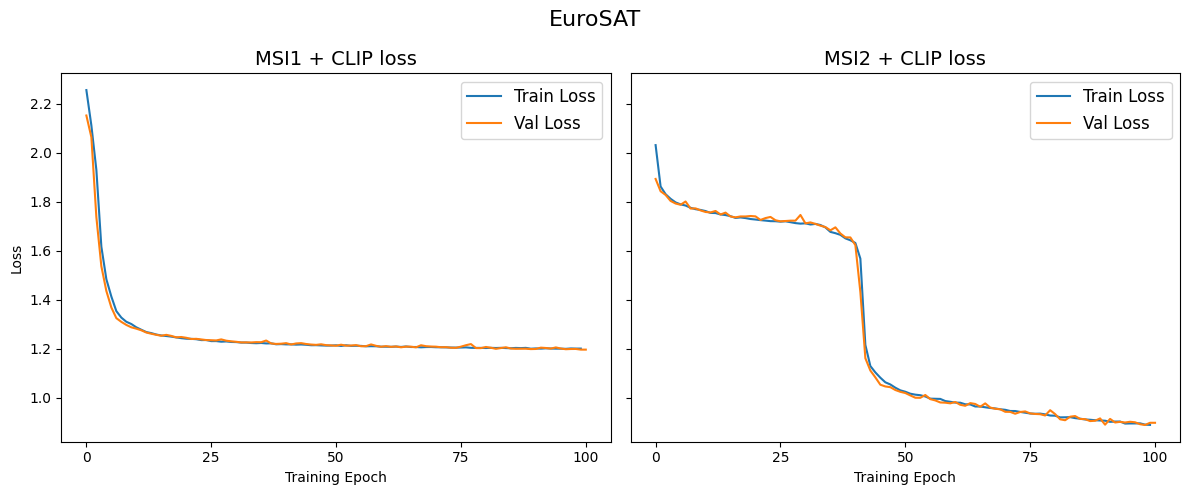

In [ ]:
plot_train_val_losses("EuroSAT", msi1_log, msi2_log)

### EuroSAT transfer 4L

In [18]:
msit_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi-transfer-eurosat-4l/version_0/metrics.csv")

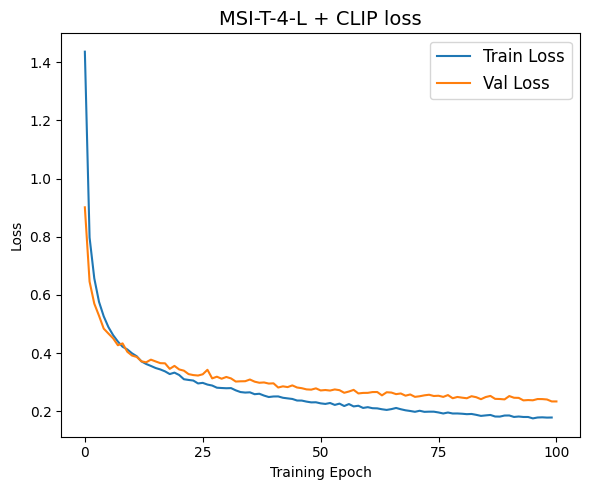

In [21]:
# Preprocess datasets
df_a = process_df(msit_log)
#df_b = process_df(df_b)

# --- Plot side by side ---
fig = plt.figure(figsize=(6, 5)) # plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot MSI1 + CLIP
plt.plot(df_a["epoch"], df_a["train_loss"], label="Train Loss")
plt.plot(df_a["epoch"], df_a["val_loss"], label="Val Loss")
plt.title("MSI-T-4-L + CLIP loss", fontsize = 14)
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.xticks([0, 25, 50, 75, 100])
plt.legend(fontsize = 12)
#axs[0].grid(axis='y')

# Plot MSI2 + CLIP
# axs[1].plot(df_b["epoch"], df_b["train_loss"], label="Train Loss")
# axs[1].plot(df_b["epoch"], df_b["val_loss"], label="Val Loss")
# axs[1].set_title("MSI2 + CLIP loss", fontsize = 14)
# axs[1].set_xlabel("Training Epoch")
# axs[1].set_xticks([0, 25, 50, 75, 100])
# axs[1].legend(fontsize = 12)
#axs[1].grid(axis='y')

#plt.title("EuroSAT", fontsize = 16)

# --- Save and show the plot ---
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Thesis CLIP4EO/img/EuroSAT_4L_loss_plot.png", dpi=300)
plt.show()


### EuroSAT lr = 5e-3

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat-lr5e-3/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat-lr5e-3/version_0/metrics.csv")

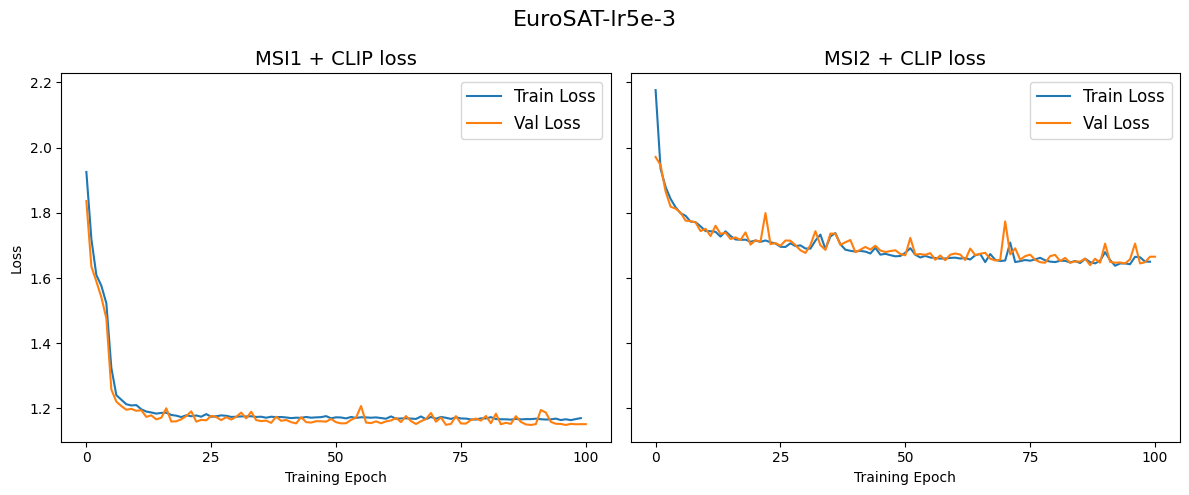

In [ ]:
plot_train_val_losses("EuroSAT-lr5e-3", msi1_log, msi2_log)

### EuroSAT norms

In [ ]:
# Files of interest (base EuroSAT version of MSI1 and MSI2)
msi1_per_image_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat/version_0/metrics.csv")
msi1_per_image_per_channel_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat-norm2/version_0/metrics.csv")
msi1_per_channel_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat-norm3/version_0/metrics.csv")

msi2_per_image_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat/version_0/metrics.csv")
msi2_per_image_per_channel_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat-norm2/version_0/metrics.csv")
msi2_per_channel_norm = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi-transfer-eurosat/version_0/metrics.csv")

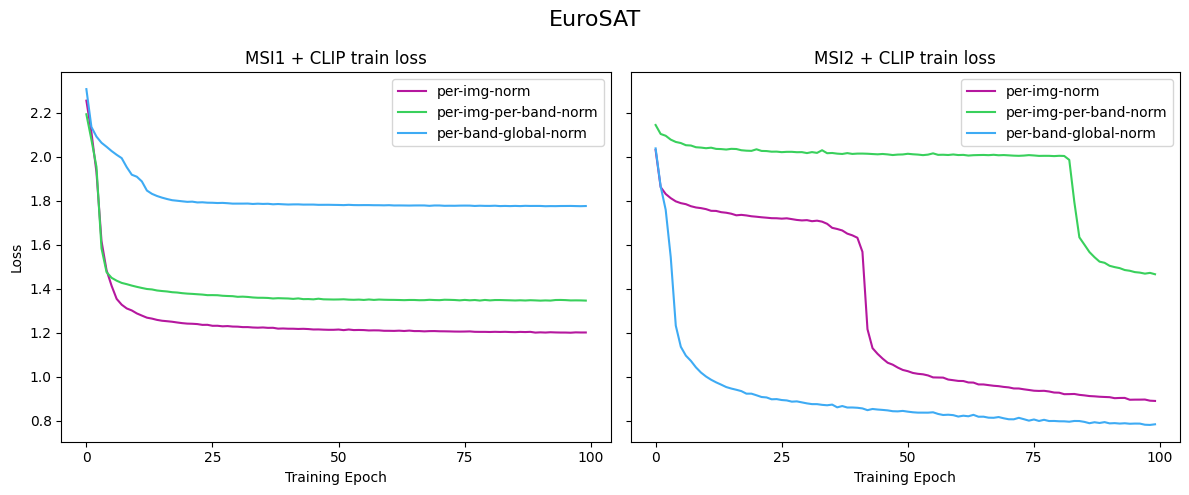

In [ ]:
def process_df(df):

    ''' Function to reaggregate the csv logs with 2-lines per epoch results. '''

    return df.groupby("epoch").agg({col: "max" for col in df.columns if col != 'epoch'}).reset_index()


model1_logs = [
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat/version_0/metrics.csv",
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat-norm2/version_0/metrics.csv",
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-eurosat-norm3/version_0/metrics.csv"
]

model2_logs = [
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat/version_0/metrics.csv",
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-eurosat-norm2/version_0/metrics.csv",
    "/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi-transfer-eurosat/version_0/metrics.csv"
]


model1_name="MSI1 + CLIP train loss",
model2_name="MSI2 + CLIP train loss",
strategies=("per-img-norm", "per-img-per-band-norm", "per-band-global-norm")

colors = ["#b5179e", "#39d05c", "#3eabf4"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for idx, (logs, ax, title) in enumerate(zip([model1_logs, model2_logs],
                                             axs,
                                            [model1_name, model2_name])):
    for i, log_path in enumerate(logs):
        df = pd.read_csv(log_path)
        df = process_df(df)
        ax.plot(df["epoch"], df["train_loss"], label=strategies[i], color = colors[i])

    ax.set_title(title[0])
    ax.set_xlabel("Training Epoch")
    ax.set_xticks([0, 25, 50, 75, 100])
    if idx == 0:
        ax.set_ylabel("Loss")
    #ax.grid(True)
    ax.legend()

plt.suptitle("EuroSAT", fontsize = 16)

plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Thesis CLIP4EO/img/EuroSAT_norm_train_losses_plot.png")
plt.show()

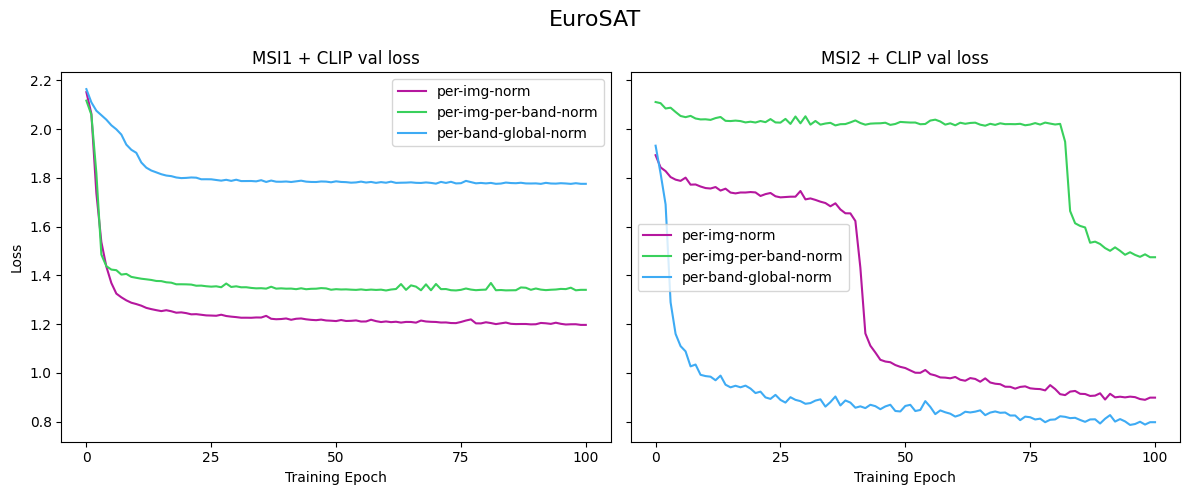

In [ ]:
model1_name="MSI1 + CLIP val loss",
model2_name="MSI2 + CLIP val loss",
strategies=("per-img-norm", "per-img-per-band-norm", "per-band-global-norm")
colors = ["#b5179e", "#39d05c", "#3eabf4"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for idx, (logs, ax, title) in enumerate(zip([model1_logs, model2_logs],
                                             axs,
                                            [model1_name, model2_name])):
    for i, log_path in enumerate(logs):
        df = pd.read_csv(log_path)
        df = process_df(df)
        ax.plot(df["epoch"], df["val_loss"], label=strategies[i], color = colors[i])

    ax.set_title(title[0])
    ax.set_xlabel("Training Epoch")
    ax.set_xticks([0, 25, 50, 75, 100])
    if idx == 0:
        ax.set_ylabel("Loss")
    #ax.grid(True)
    ax.legend()

plt.suptitle("EuroSAT", fontsize = 16)

plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Thesis CLIP4EO/img/EuroSAT_norm_val_losses_plot.png")
plt.show()

### m-brick-kiln

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-brick/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-brick/version_0/metrics.csv")

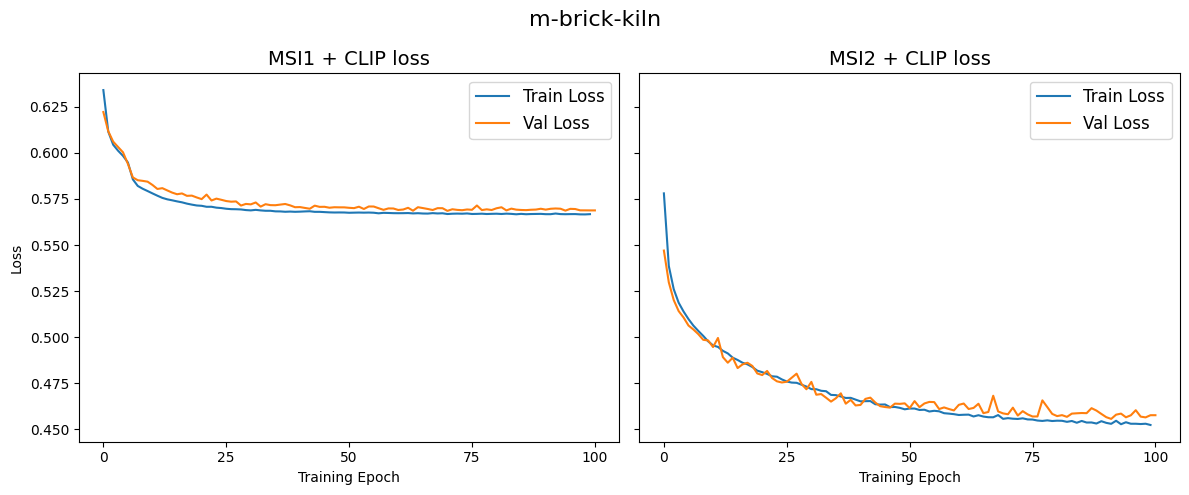

In [ ]:
plot_train_val_losses("m-brick-kiln", msi1_log, msi2_log)

### m-pv4ger

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-pv4ger/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-pv4ger/version_0/metrics.csv")

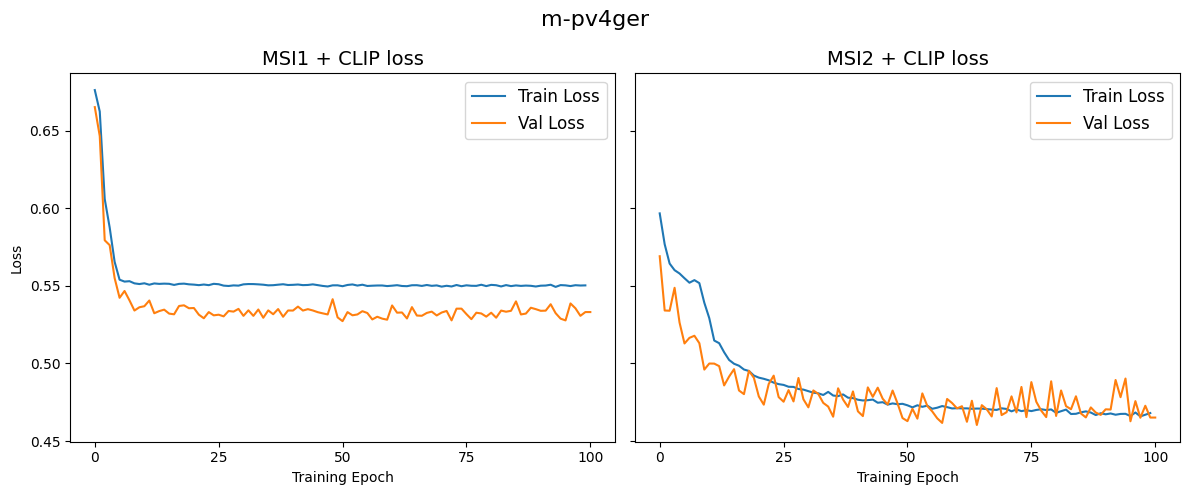

In [ ]:
plot_train_val_losses("m-pv4ger", msi1_log, msi2_log)

### m-forestnet

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-forestnet/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-forestnet/version_0/metrics.csv")

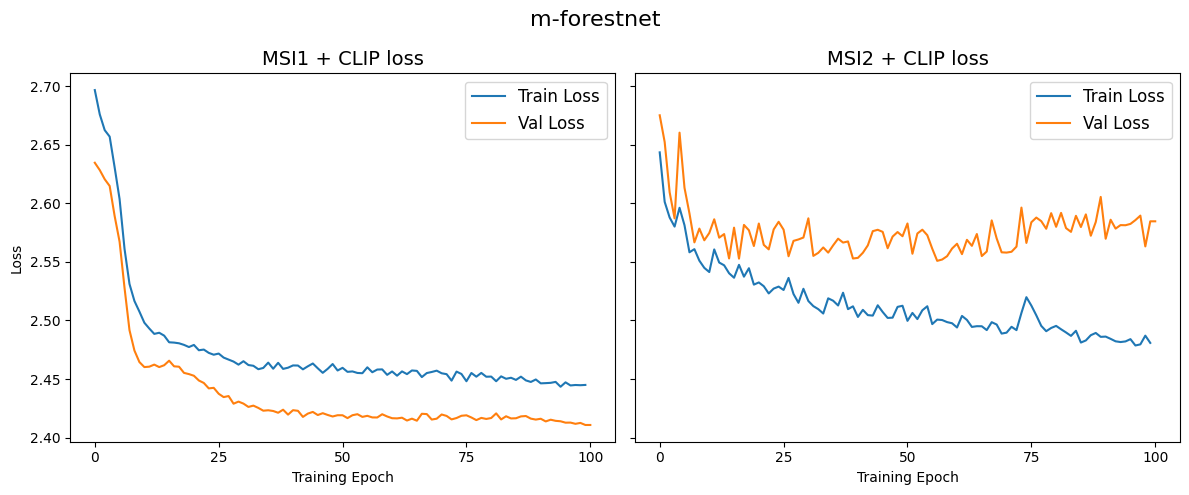

In [ ]:
plot_train_val_losses("m-forestnet", msi1_log, msi2_log)

### m-eurosat

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-eurosat/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-eurosat/version_0/metrics.csv")

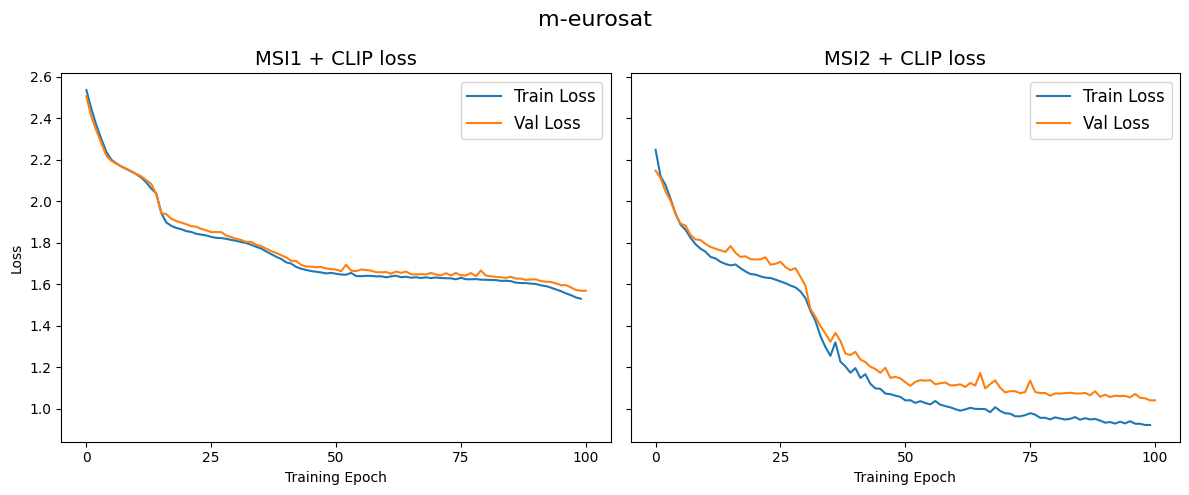

In [ ]:
plot_train_val_losses("m-eurosat", msi1_log, msi2_log)

### m-so2sat

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-so2sat/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-so2sat/version_0/metrics.csv")

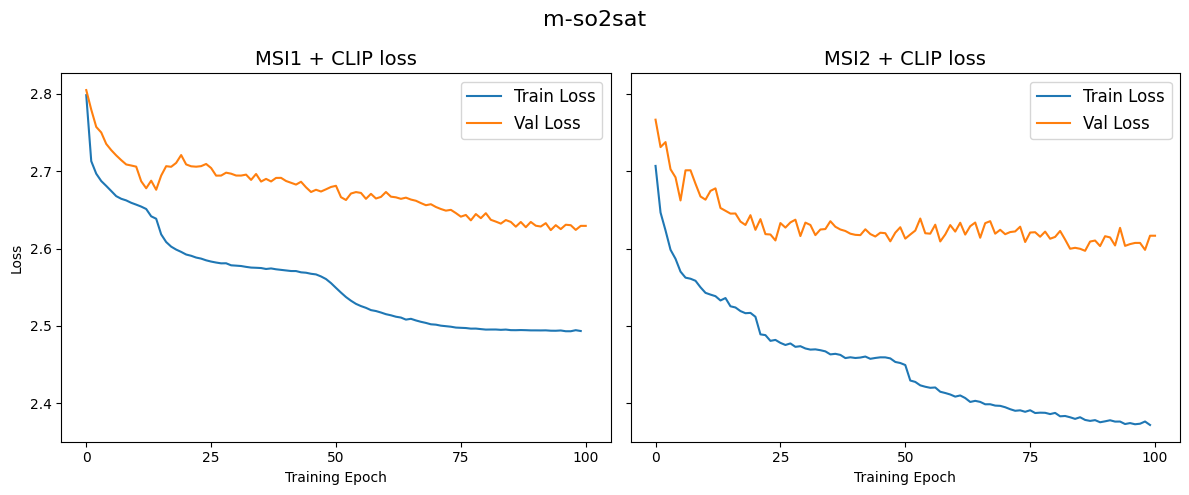

In [ ]:
plot_train_val_losses("m-so2sat", msi1_log, msi2_log)

### m-bigearthnet

In [ ]:
msi1_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi1-geobench-bigearthnet/version_0/metrics.csv")
msi2_log = pd.read_csv("/content/drive/MyDrive/Thesis CLIP4EO/logs/clip-msi2-geobench-bigearthnet/version_0/metrics.csv")

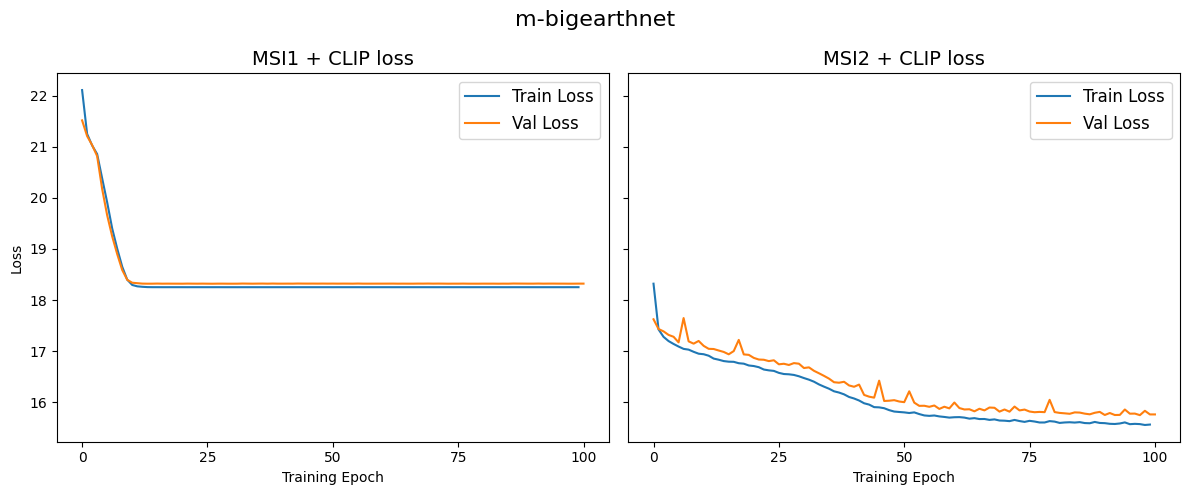

In [ ]:
plot_train_val_losses("m-bigearthnet", msi1_log, msi2_log)

 ## Understanding channel importance


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import torch
from captum.attr import IntegratedGradients


# Use vanilla gradients to understand how a small change in x input channel changes the final output
def calculate_channel_importances(embedder, original_image):
    """
    Calculate the importance of each channel in the original image
    based on the gradients of a scalar output derived from the embedded image.

    Args:
        embedder (nn.Module): The embedder model.
        original_image (torch.Tensor): Input image tensor with shape
                                       [batch_size, C_original, H, W].

    Returns:
        torch.Tensor: A tensor of shape [C_original] representing the importance
                      of each channel, normalized to sum to 1.
    """
    embedded_image = embedder(original_image) # forward pass through my embedder -> shape [B, 3, H, W]

    scalar_output = embedded_image.sum()

    scalar_output.backward()

    gradients = original_image.grad

    channel_importances = torch.mean(gradients.abs(), dim=(0, 2, 3)).detach() # mean absolute gradient per input channel

    return channel_importances / torch.sum(channel_importances) # normalize to have an importance distribution that sums to 1


# More stable, IG approximates the integral of gradients along the path from baseline -> input. Smoother and less noisy scores
def calculate_integrated_gradient_importances(embedder, original_image):
    """
    Calculate the importance of each channel in the original image
    using Integrated Gradients.

    Args:
        embedder (nn.Module): The embedder model.
        original_image (torch.Tensor): Input image tensor with shape
                                       [batch_size, C_original, H, W].

    Returns:
        torch.Tensor: A tensor of shape [C_original] representing the importance
                      of each channel, normalized to sum to 1.
    """
    def forward_for_ig(input_tensor):
        # Ensure input_tensor has a batch dimension if your model expects it
        if input_tensor.dim() == 3: # If input is (C, H, W)
            input_tensor = input_tensor.unsqueeze(0)

        output_3_channel = embedder(input_tensor)
        return output_3_channel.sum().unsqueeze(0) # Sum all pixels for a scalar target

    ig = IntegratedGradients(forward_for_ig)
    baseline = torch.zeros_like(original_image)

    attributions = ig.attribute(original_image, baselines=baseline, n_steps=50)

    channel_importances = attributions.abs().mean(dim=(0, 2, 3)).detach()

    return channel_importances / torch.sum(channel_importances)
